In [1]:
from scipy.integrate import ode, complex_ode
from scipy.interpolate import interp1d
import pandas as pd
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm.notebook import tqdm_notebook as tqdm
import time
from scipy.optimize import minimize, approx_fprime, minimize_scalar,curve_fit

In [2]:
import matplotlib as mpl
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.autolayout'] = True 
def utkarshGrid():
    plt.minorticks_on()
    plt.grid(color='grey',
             which='minor',
             linestyle=":",
             linewidth='0.1',
             )
    plt.grid(color='black',
             which='major',
             linestyle=":",
             linewidth='0.1',
             )

In [3]:
np.set_printoptions(precision=2)

In [4]:
G = 6.67259e-8 # dyne cm2 g-2
c = 2.99792458e10 # cms-1
n_den = 2.3e14
km2cm = 1e5
msun = 1.98847e33

def lamba_metric(M, R):
    return -np.log((1-2*G*M/(c**2*R)))

def df_to_ep(df):
    e_den = df.energy_densityc2
    p_arr = df.pressurec2
    p = p_arr[p_arr > 1e8] # Originally 1e8
    e_den = e_den[p_arr > 1e8]
    e_den = e_den*((2.99792458e10)**2)
    pressure = p*((2.99792458e10)**2)
    return e_den.to_numpy(), pressure.to_numpy()
def get_ep(e, p):
    f_e_smooth = interp1d(p, e, fill_value= "extrapolate", kind = "cubic")
    return f_e_smooth
def get_pe(p, e):
    f_e_smooth = interp1d(e, p, fill_value=(0, 0), kind = "cubic", bounds_error=True)
    return f_e_smooth


path = "2205.02081/NL3.csv"
df = pd.read_csv(path)
e_arr, p_arr = df_to_ep(df)
e, p = df_to_ep(df)
p_max = max(p)
p_min = max(1*(c**2), min(p)) 
EOS = get_ep(e, p)

In [5]:
def _dMdr(r, e):
    return 4 * np.pi * r**2 * (e/(c**2))
def _b(r, M):
    return (G*M)/((c**2)*r)
def _dnudr(r, Q, lamda):
    return (2/r) * np.exp(lamda) * Q
def _Q(r, P, M):
    frac = (4 * np.pi * G * (r**2)*P)/(c**4)
    return _b(r, M) + frac
def _dPdr(r, P, M, e):    
    num = (M+4*np.pi*(r**3)*P/(c**2))
    dem = r * (r-2*G*M/(c**2))
    return -1 * (e+P) * G/(c**2) * num/dem
def dedP_helper(p, e):
    return np.gradient(e, p), e
def dedP(p, e):
    dedp_helper, e_arr = dedP_helper(p, e)
    return interp1d(e_arr, dedp_helper, fill_value="extrapolate", kind = "cubic")
def drhodP(e, dedp = dedP(p, e)):
    return (c**-2) * dedp(e)

In [6]:
# DIMENSIONS CHECKED
def _H0(r, nu, X, nl, Q, omega, lamda, H1, b, K):
    omgr2_c2 = ((omega * r)**2)/(c**2)
    factor = (2*b + nl + Q) ** (-1)
    term1 = 8 * np.pi * (r**2) * np.exp(-nu/2) * X * (G/(c**4))
    term2 = - H1 * (Q*(nl+1) - omgr2_c2 * np.exp(-nu-lamda))
    term3 = K * (nl - omgr2_c2*np.exp(-nu)-Q*(np.exp(lamda)*Q-1))
    return factor * (term1 + term2 + term3)

# DIMENSIONS CHECKED
def _V(r, X, e, p, Q, nu, lamda, W, H0, omega):
    factor = np.exp(nu/2) * (c**2)/(omega**2)
    term1 = X/(e+p)
    term2 = -Q/(r**2) * W * np.exp((nu+lamda)/2)
    term3 = -np.exp(nu/2)*H0/2
    return factor * (term1 + term2 + term3)

In [7]:
## arXiv 2205.02081 ##
# DIMENSIONS CHECKED
def _dH1dr(r, l, b, lamda, p, e, H1, H0, K, V):
    G_c4 = G/(c**4)
    term1 = -H1*(l + 1 + 2*b*np.exp(lamda) + G_c4 * 4*np.pi*(r**2)*np.exp(lamda)*(p-e))
    term2 = np.exp(lamda) * (H0 + K - G_c4*16*np.pi*(e+p)*V)
    return (1/r) * (term1 + term2)

# DIMENSIONS CHECKED
def _dKdr(r, H0, nl, H1, lamda, Q, l, K, e, p, W):
    term1 = H0
    term2 = (nl+1)*H1
    term3 = (np.exp(lamda)*Q-l-1)*K
    term4 = -8*np.pi*(e+p)*np.exp(lamda/2)*W*G/(c**4)
    return (1/r) * (term1 + term2 + term3 + term4)

# DIMENSIONS CHECKED
def _dWdR(r, W, l, lamda, V, e, p, X, cad2_inv, H0, K, nu):
    term1 = -(l+1)*(W+l*np.exp(lamda/2)*V)
    term2_fac = (r**2 * np.exp(lamda/2))
    term2_1 = (np.exp(-nu/2)*X*(c**2) * cad2_inv)/(e+p)
    term2_2 = H0/2
    term2_3 = K
    term2 = term2_fac * (term2_1 + term2_2 + term2_3)
    return (1/r) * (term1 + term2)

# DIMENSIONS CHECKED 2205.02081
def _dXdr(r, l, X, e, p, nu, lamda, Q, H0, omega, nl, H1, K, V, W, derivative_term):
    omgr2_c2 = ((omega * r)**2)/(c**2)
    G_c4 = G/(c**4)
    term1 = -l*X
    term2_fac = (e+p)*np.exp(nu/2)/2
    term2_1 = (1-np.exp(lamda)*Q)*H0
    term2_2 = H1 * (omgr2_c2*np.exp(-nu) + nl + 1)
    term2_3 = K * (3*np.exp(lamda)*Q - 1)
    term2_4 = -4 * (nl + 1) * np.exp(lamda) * Q * V/(r**2)
    term2_5_fac = -2*W
    term2_5_1 = np.exp(lamda/2 - nu)*(omega**2)/(c**2)  
    term2_5_2 = G_c4 * 4 * np.pi * (e+p) * np.exp(lamda/2)
    term2_5_3 = -(r**2) * derivative_term 
    term2_5 =  term2_5_fac * (term2_5_1 + term2_5_2 + term2_5_3)
    term2 = term2_fac * (term2_1 + term2_2 + term2_3 + term2_4 + term2_5)
    return (1/r) * (term1 + term2)

In [8]:
def derivative_term(r, dMdr, dPdr, m, P):
    pi = np.pi
    exp = np.exp
    sqrt = np.sqrt
    return G*(G*(dMdr*r - m)*(4*pi*P*r**3 + c**2*m) - 6*(-2*G*m + c**2*r)*(4*pi*P*r**3 + c**2*m) + 2*(-2*G*m + c**2*r)*(c**2*dMdr*r - c**2*m + 4*pi*r**3*(2*P + dPdr*r)))/(2*c**6*r**6*((-2*G*m + c**2*r)/(c**2*r))**(5/4))

In [9]:
def coupledTOV(r, VEC, init_params):
    P, M, nu, H1, K, W, X = VEC
    EOS, l, omega, p_min, p_max, nl = init_params

    if P <= p_min: 
        return None
    if P >= p_max:
        return None
    if 2*_b(r, M) >= 1:
        return None

    b = _b(r, M)
    lamda = np.log(1/(1-2*b))
    Q = _Q(r, P, M)
    e = EOS(np.real(P)) 
    cad2_inv = drhodP(e)
    
    dPdr = _dPdr(r, P, M, e)
    dMdr = _dMdr(r, e)
    
    derv_term = derivative_term(r, dMdr, dPdr, M, P)
    
    dnudr = _dnudr(r, Q, lamda)
    H0 = _H0(r, nu, X, nl, Q, omega, lamda, H1, b, K)
    V = _V(r, X, e, P, Q, nu, lamda, W, H0, omega)
    
    # arXiv 2205.02081
    dH1dr = _dH1dr(r, l, b, lamda, P, e, H1, H0, K, V)
    dKdr = _dKdr(r, H0, nl, H1, lamda, Q, l, K, e, P, W)
    dWdr = _dWdR(r, W, l, lamda, V, e, P, X, cad2_inv, H0, K, nu)
    dXdr = _dXdr(r, l, X, e, P, nu, lamda, Q, H0, omega, nl, H1, K, V, W, derv_term)
    
    ret = [dPdr, dMdr, dnudr, dH1dr, dKdr, dWdr, dXdr]
    return ret

In [10]:
def tov(EOS, init_VEC, r_i, p_min,p_max, omega,nl, progress = False, 
        l=2, n_iter_max = 20000):
    init_params = [EOS, l, omega, p_min, p_max, nl]
    r = complex_ode(lambda r, VEC: coupledTOV(r, VEC, init_params)).set_integrator('VODE')
    r.set_initial_value(init_VEC, r_i)
    results = [init_VEC]
    r_list = [r_i]
    i = 0
    r_max = 20 * km2cm
    max_iter = n_iter_max
    dr = r_max/max_iter
    m_max = 0
    if progress:
        pbar = tqdm(total=max_iter)
    while r.successful() and (np.real(r.y[0]) >= p_min):
        i+=1
        integral = r.integrate(r.t+dr)
        if progress:
            pbar.update(1)
        # Break conditions
        if i > max_iter:
            print("[STATUS] max_iter reached")
            break
        if (np.real(r.y[0]) < p_min):
            break
        if not r.successful():
            break
        if r.y[1] < m_max:
            break 
        m_max = max(r.y[1], m_max)
        results.append(integral)
        r_list.append(r.t+dr)
    if progress:
        pbar.close()
#     print("Integration, Pressure: ", r.successful(), (r.y[0] >= p_min))
    
    results = np.array(results, dtype = complex)
    p, m, nu, h1, k, w, x = results.T
    r = np.array(r_list, dtype = float)
    return p, m, r, nu, h1, k, w, x

In [11]:
def initial_conditions_helper(K0, e_c, p_c, nu0, omega, W0, nl, l, p0, e0):
    # DIMENSIONS CHECKED
    e_c = e0
    p_c = p0
    X0_factor = (e_c + p_c) * np.exp(nu0/2)
    X0_term1 = 4 * np.pi/3 * (e_c + 3*p_c) * W0 * G/(c**4)
    X0_term2 = -(omega**2)/l * np.exp(-nu0) * W0  /(c**2)
    X0_term3 = K0/2
    X0 = X0_factor * (X0_term1 + X0_term2 + X0_term3)
    H00 = K0
    H10 = (l*K0 + 8*np.pi*(G/(c**4))*(e_c+p_c)*W0)/((nl+1))
    return X0, H00, H10

def initial_conditions(EOS, e, p, k, km2cm = 1e5, r_i = 1, K0 = None):
    p0 = p[k]
    e0 = EOS(p0)
    p_c = p0 - 2 * np.pi * (G/(c**4)) * r_i**2 * (p0 + e0) * (3*p0 + e0)/3
    e_c = EOS(p_c)
    m0 = e_c/(c**2) * 4/3 * np.pi * r_i**3
    l=2 
    nl = (l-1)*(l+2)/2
    nu0 = -1 
    Q0 = _Q(r_i, p_c, m0)
    b0 = _b(r_i, m0)
    W0 = 1

    if K0 == None:
        K0 =  -(e_c + p_c) * (G/(c**4))
    
    X0, H00, H10 = initial_conditions_helper(K0, e_c, p_c, nu0, omega, W0, nl, l, p0, e0)
    init_VEC = [p_c, m0, nu0, H10, K0, W0, X0]
    p_max = max(p)
    p_min = max(c**2, min(p)) 
    return p_c, e_c, m0, omega, l, nl, nu0, Q0, b0, W0, K0, X0, H00, H10, init_VEC, \
    p_max, p_min, r_i, p0, e0

def surface_conditions(p, m, r_arr, nu, h1, k, w, x):
    max_idx = np.argmax(m) - 1
    m_R = m.max() # In units of msun
    r_R = r_arr[max_idx] # In units of km
    p_R = p[max_idx] #cgs
    ec_R = EOS(np.real(p_R)) #cgs
    nu_R = nu[max_idx]
    h1_R = h1[max_idx]
    k_R = k[max_idx]
    w_R = w[max_idx]
    x_R = x[max_idx]
    schild = (1-2*G*m_R/(c**2*r_R))
    interior = np.exp(nu_R)
    return max_idx, m_R, r_R, p_R, ec_R, nu_R, h1_R, k_R, w_R, x_R, schild, interior

def print_params(p, m, r_arr, nu, h1, k, w, x):
    max_idx, m_R, r_R, p_R, ec_R, nu_R, h1_R, k_R, w_R, x_R, schild, \
    interior = surface_conditions(p, m, r_arr, nu, h1, k, w, x)
    print(f"Star has mass {m_R/msun:.3f} Msun and radius {r_R/km2cm:.3f}km")
    print(f"Interior Surface: {interior:.8f}")
    print(f"Exterior Surface: {schild:.8f}")
    print(f"v0: {nu0}")
    print(f"Lamda: {lamba_metric(m_R, r_R)}")
    print(f"Boundary Term: {x_R}")
    return None

In [12]:
def V_z_alt(r, m_R, nl):
    b = _b(r, m_R)
    n = nl
    fac = (1-2*b)
    num = 2*(n**2)*(n+1) + 6*(n**2)*b + 18*n*(b**2) + 18*(b**3)
    dem = (r**2) * (n+3*b)**2
    return fac * num/dem

def r_star_func(r, m_R):
    return r + 2 * (G/(c**2)) * m_R * np.log(abs((r*(c**2))/(2*G*m_R) - 1))

def zerilli_alt(r_star, u, omega):
    z, dZdr_star = u
    m = m_R
    d2Zdr2_star = z * (V_z_alt(r_star, m_R, nl) - omega*np.conj(omega)/(c**2))
    ret = [dZdr_star, d2Zdr2_star] # dZ/dr*, d2Z/dr*2
    return ret 

def alphas(omega, nl, m_R):
    n = nl
    alpha0 = 1 + 1j
    alpha1 = -1j*(n+1)*alpha0*c/omega
    alpha2 = alpha0 * (c**2)*(-n*(n+1)+1j*m_R*omega*(G/(c**3))*(3/2 + 3/n))/(2*omega**2)
    return alpha0, alpha1, alpha2

# # 1983 Version
def r_star_func(r, m_R):
    return r + 2 * (G/(c**2)) * m_R * np.log(abs((r*(c**2))/(2*G*m_R) - 1))

def V_z(r, m_R, nl):
    G_c2 = G/(c**2)
    num = (1-2*G_c2*m_R/r)
    dem = (r**3)*((nl*r+3*G_c2*m_R)**2)
    fac1 = 2*nl**2*(nl+1)*(r**3)
    fac2 = 6*(G_c2**1)*(nl**2)*m_R*(r**2)
    fac3 = 18*(G_c2**2)*nl*(m_R**2)*r
    fac4 = 18*(G_c2**3)*(m_R**3)
    fac = fac1 + fac2 + fac3 + fac4
    ret = fac * num/dem
    return ret

def zerilli(r_star, u, omega):
    omega2 = pow(omega, 2)
    z, dZdr_star = u
    m = m_R
    d2Zdr2_star = z * (V_z(r_star, m_R, nl) - omega2/(c**2))
    ret = [dZdr_star, d2Zdr2_star] # dZ/dr*, d2Z/dr*2
    return ret 

def zrly(omega, r_star_vals, progress = True):
    r = complex_ode(lambda r, VEC: zerilli(r, VEC, omega)).set_integrator('LSODA', atol = 1.49012e-8, rtol = 1.49012e-8)
    r.set_initial_value(z0, r_star_func(r_R, np.real(m_R)))
    results = [z0]
    r_list = [r_star_func(r_R, m_R)]
    i = 0
    if progress:
        pbar = tqdm(total=len(r_star_vals))
    while r.successful():
        i += 1
        if i >= len(r_star_vals):
            break
        if progress:
            pbar.update(1)
        
        integral = r.integrate(r_star_vals[i])
        if not r.successful():
            break
        results.append(integral)
        r_list.append(r_star_vals[i])
    results = np.array(results, dtype = complex)
    z, dzdr = results.T
    r = np.array(r_list)
    return z, dzdr, r

In [13]:
hw1, hw2, hw3 = [300, 100, 30]


## Max Mass

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/integrate/_ode.py:1011: UserWarning: vode: Excess work done on this call. (Perhaps wrong MF.)
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


[ERROR] Radius is only 1e-05km. Skipping...



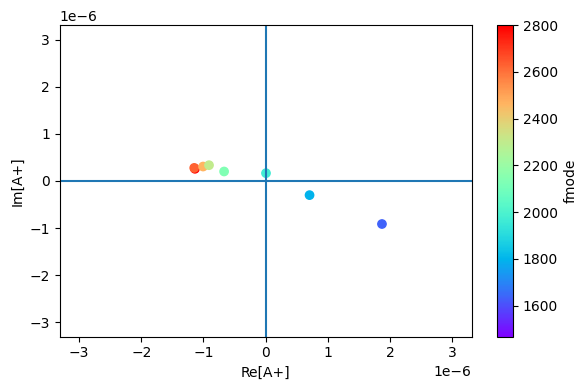

1976.3527054108215
Search Successful!
Fmode = 1976Hz


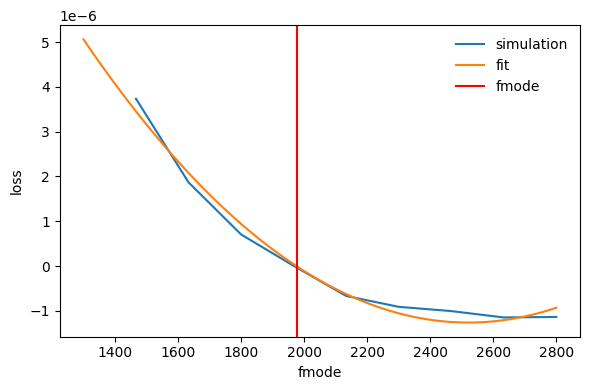

3065.8285573411285 1975.33724865733
1976.3527054108215


In [14]:
# NL3
index = -660
# index = -1028


# SLY230A
# index = -16
# index = -71

# SLY4
# index = -27
# index = -91

imag = 5j
# omega = 1.932e3 * 2 * np.pi + imag
fmin = 2.8e3
fmax = 1.3e3

for_loop = tqdm(np.linspace(fmin*2*np.pi + imag, fmax*2*np.pi + imag, 10))
# for_loop = tqdm([2.591e3 * 2 * np.pi + imag, 2.591e3 * 2 * np.pi + imag, 2.591e3 * 2 * np.pi + imag])

omega_vals = []
loss_vals = []
abs_loss_vals = []

for omega in for_loop:

    p_c, e_c, m0, omega, l, nl, nu0, Q0, b0, W0, K0, X0, H00, H10, init_VEC, \
    p_max, p_min, r_i, p0, e0 = initial_conditions(EOS, e_arr, p_arr, index, omega)

    p, m, r_arr, nu, h1, k, w, x = tov(EOS, init_VEC, r_i, p_min,p_max, 
                               omega, nl, progress = False, l = l, 
                                       n_iter_max = 20000 * 10)

    max_idx, m_R, r_R, p_R, ec_R, nu_R, h1_R, k_R, w_R, x_R, schild, \
    interior = surface_conditions(p, m, r_arr, nu, h1, k, w, x)

    # Update init_VEC
    nu_ext = -lamba_metric(m_R, r_R)
    nu_int = nu_R #At surface
    delta_nu = nu_int - nu_ext
    nu0 =  nu0 - delta_nu

    X0, H00, H10 = initial_conditions_helper(K0, e_c, p_c, nu0, omega, W0, nl, l, p0, e0)
    init_VEC = [p_c, m0, nu0, H10, K0, W0, X0]
    time.sleep(0.2)

    p, m, r_arr, nu, h1, k, w, x = tov(EOS, init_VEC, r_i, p_min,p_max, 
                               omega, nl, progress = False, l = l)

    max_idx, m_R, r_R, p_R, ec_R, nu_R, h1_R, k_R, w_R, x_R, schild, \
    interior = surface_conditions(p, m, r_arr, nu, h1, k, w, x)

    # Update init_VEC
    nu_ext = -lamba_metric(m_R, r_R)
    nu_int = nu_R #At surface
    delta_nu = nu_int - nu_ext
    nu0 =  nu0 - delta_nu

    X0, H00, H10 = initial_conditions_helper(K0, e_c, p_c, nu0, omega, W0, nl, l, p0, e0)
    init_VEC = [p_c, m0, nu0, H10, K0, W0, X0]
    time.sleep(0.2)

    p, m, r_arr, nu, h1, k, w, x = tov(EOS, init_VEC, r_i, p_min,p_max, 
                               omega, nl, progress = False, l = l)

    max_idx, m_R, r_R, p_R, ec_R, nu_R, h1_R, k_R, w_R, x_R, schild, \
    interior = surface_conditions(p, m, r_arr, nu, h1, k, w, x)

    
    if r_R < 3*km2cm:
        print(f"[ERROR] Radius is only {r_R/km2cm}km. Skipping...")
        continue

    def optimize_x_R(K0):

        # Update Initial Conditions in terms of K0    
        X0, H00, H10 = initial_conditions_helper(K0, e_c, p_c, nu0, omega, W0, nl, l, p0, e0)
        init_VEC = np.array([p_c, m0, nu0, H10, K0, W0, X0], dtype = complex).flatten()
        p, m, r_arr, nu, h1, k, w, x = tov(EOS, init_VEC, r_i, p_min,p_max, 
                                           omega, nl, progress = False, l = l, n_iter_max = 20000)
        max_idx, m_R, r_R, p_R, ec_R, nu_R, h1_R, k_R, w_R, x_R, schild, \
        interior = surface_conditions(p, m, r_arr, nu, h1, k, w, x)
        loss = np.log10(abs(x_R)) # Absolute loss of complex B.C.
        return loss

    K0_guess = K0
    init_guess = [K0_guess]
    res = minimize(optimize_x_R, x0 = init_guess, method='Nelder-Mead', 
                   options = {"disp": True, "maxiter":20, "fatol": 1e-20})


    K0 = res.x[0]
    X0_factor = (e_c + p_c) * np.exp(nu0/2)
    X0_term1 = 4 * np.pi/3 * (e_c + 3*p_c) * W0 * G/(c**4)
    X0_term2 = -(omega**2)/l * np.exp(-nu0) * W0  /(c**2)
    X0_term3 = K0/2
    X0 = X0_factor * (X0_term1 + X0_term2 + X0_term3)
    H00 = K0
    H10 = (l*K0 + 8*np.pi*(G/(c**4))*(e_c+p_c)*W0)/((nl+1))

    init_VEC = [p_c, m0, nu0, H10, K0, W0, X0]
    time.sleep(0.2)

    p, m, r_arr, nu, h1, k, w, x = tov(EOS, init_VEC, r_i, p_min,p_max, 
                               omega, nl, progress = False, l = l)

    max_idx, m_R, r_R, p_R, ec_R, nu_R, h1_R, k_R, w_R, x_R, schild, \
    interior = surface_conditions(p, m, r_arr, nu, h1, k, w, x)
    

    
    h1r = h1_R
    Kr = k_R
    b = _b(r_R, m_R)
    n = nl
    r = r_R
    z_R = r*(Kr/(1 - 2*b) - h1r)/(-(-3*b**2 - 3*b*n + n)/((1 - 2*b)*(3*b + n)) + (6*b**2 + 3*b*n + n*(n + 1))/((1 - 2*b)*(3*b + n)))
    dzdR_R = (-Kr*(-3*b**2 - 3*b*n + n)/((1 - 2*b)*(3*b + n)) + h1r*(6*b**2 + 3*b*n + n*(n + 1))/(3*b + n))/(-(-3*b**2 - 3*b*n + n)/((1 - 2*b)*(3*b + n)) + (6*b**2 + 3*b*n + n*(n + 1))/((1 - 2*b)*(3*b + n)))
    z0 = [z_R, dzdR_R]
#     print(z0, r_R)

    alpha0, alpha1, alpha2 = alphas(omega, nl, m_R)
    # From surface to inf
    r_vals = np.linspace(r_R, 25 * c / np.real(omega), 500)
    r_star_vals = r_star_func(r_vals, np.real(m_R))
    z, dzdr_star, r_int = zrly(omega, r_star_vals, progress = False)
    # Save final values
    zFinal = z[-1]
    zPrimeFinal = dzdr_star[-1]
    rFinal = r_vals[-1]
    rStarFinal = r_star_vals[-1]

    b = _b(rFinal, m_R)
    
    
    # Z+/-
    zMinus = np.exp(-1j*(omega/c)*rStarFinal) * (alpha0 + alpha1/rFinal + alpha2/(rFinal**2))
    zPlus = np.conjugate(zMinus)

    # Zprime +/-
    zPrimeMinus = -1j*(omega/c)*np.exp(-1j*(omega/c)*rStarFinal) \
                * (alpha0 + alpha1/rFinal + (alpha2 + 1j*alpha1*(1-2*b)*c/omega)/(rFinal**2))
    zPrimePlus = np.conjugate(zPrimeMinus)

    # A+
    A_plus = -zFinal*zPrimeMinus/(zMinus*zPrimePlus - zPlus*zPrimeMinus) \
            + zMinus*zPrimeFinal/(zMinus*zPrimePlus - zPlus*zPrimeMinus)

    # A-
    A_minus = -zFinal*zPrimePlus/(-zMinus*zPrimePlus + zPlus*zPrimeMinus) \
             + zPlus*zPrimeFinal/(-zMinus*zPrimePlus + zPlus*zPrimeMinus)

    loss = A_plus
    abs_loss = abs(loss)
    
    if abs_loss > 1e3:
        continue
        
    omega_vals.append(omega)
    loss_vals.append(loss)
    abs_loss_vals.append(abs_loss)

omega_arr = np.array(omega_vals)
loss_arr = np.array(loss_vals)
abs_loss_arr = np.array(abs_loss_vals)
fmode_arr = np.real(omega_arr/(2*np.pi))

plt.figure(dpi = 100)
sc = plt.scatter(np.real(loss_arr),np.imag(loss_arr), c = 
                 fmode_arr, cmap = cm.rainbow)
plt.xlabel("Re[A+]")
plt.ylabel("Im[A+]")
plt.colorbar(sc, label = "fmode")
plt.tight_layout()
plt.axhline(0)
plt.axvline(0)
lim = 20*min(np.abs(loss_arr))
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
plt.show()

def quadratic(x, a, b, c):
    return a*(x**2)+b*(x)+c

vec = np.real(loss_arr)
popt, pcov = curve_fit(quadratic, xdata = np.real(fmode_arr), ydata = vec)
f_arr = np.linspace(fmin*2*np.pi + imag, fmax*2*np.pi + imag, 500)/(2*np.pi)
fmode = np.real(f_arr[np.argmin(np.abs(quadratic(np.real(f_arr), *popt)))])
print(fmode)

if np.isclose(np.real(fmode), min(np.real(fmode_arr))) or np.isclose(np.real(fmode), max(np.real(fmode_arr))):
    print("Search Failed")
else:
    print(f"Search Successful!\nFmode = {round(fmode)}Hz")

_math_a,_math_b,_math_c = popt
det = np.sqrt(_math_b**2 - 4*_math_a*_math_c)
fmode1 = (-_math_b + det)/(2*_math_a)
fmode2 = (-_math_b - det)/(2*_math_a)

if abs(fmode1 - fmode2)<250:
    fmode = (fmode1 + fmode2)/2
    
plt.figure(dpi = 100)
plt.plot(np.real(fmode_arr), vec, label = "simulation")
plt.plot(np.real(f_arr), quadratic(np.real(f_arr), *popt), label = "fit")
plt.axvline(fmode, label = "fmode", color = "red")
plt.xlabel("fmode")
plt.ylabel("loss")
plt.legend()
plt.show()


print(fmode1, fmode2)
print(fmode)

fguess = fmode
    # print(np.array([h1[0], -k[0], x[0], w[0]]))

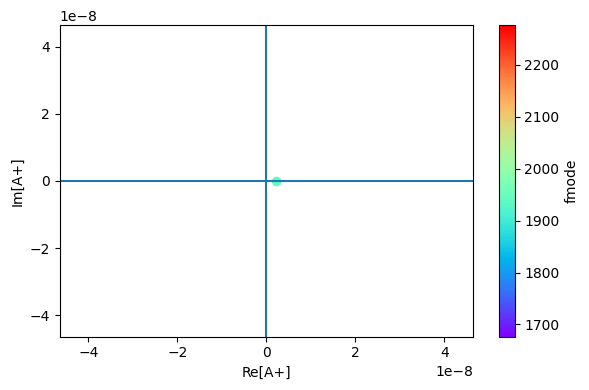

1950.5010020040081
Search Successful!
Fmode = 1951Hz


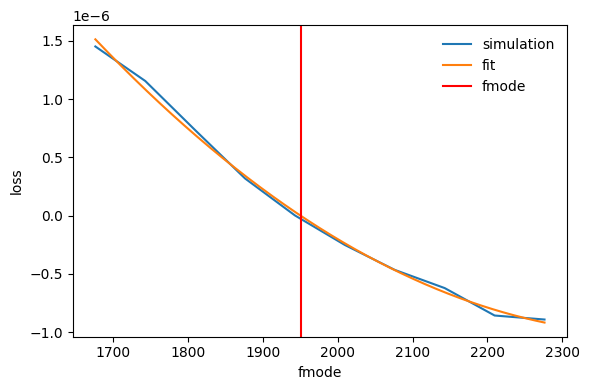

2900.697454782768 1950.6398196942466
1950.5010020040081


In [15]:
hw = hw1
fmin = fguess-hw
fmax = fguess+hw

for_loop = tqdm(np.linspace(fmin*2*np.pi + imag, fmax*2*np.pi + imag, 10))
# for_loop = tqdm([2.591e3 * 2 * np.pi + imag, 2.591e3 * 2 * np.pi + imag, 2.591e3 * 2 * np.pi + imag])

omega_vals = []
loss_vals = []
abs_loss_vals = []

for omega in for_loop:

    p_c, e_c, m0, omega, l, nl, nu0, Q0, b0, W0, K0, X0, H00, H10, init_VEC, \
    p_max, p_min, r_i, p0, e0 = initial_conditions(EOS, e_arr, p_arr, index, omega)

    p, m, r_arr, nu, h1, k, w, x = tov(EOS, init_VEC, r_i, p_min,p_max, 
                               omega, nl, progress = False, l = l, 
                                       n_iter_max = 20000 * 10)

    max_idx, m_R, r_R, p_R, ec_R, nu_R, h1_R, k_R, w_R, x_R, schild, \
    interior = surface_conditions(p, m, r_arr, nu, h1, k, w, x)

    # Update init_VEC
    nu_ext = -lamba_metric(m_R, r_R)
    nu_int = nu_R #At surface
    delta_nu = nu_int - nu_ext
    nu0 =  nu0 - delta_nu

    X0, H00, H10 = initial_conditions_helper(K0, e_c, p_c, nu0, omega, W0, nl, l, p0, e0)
    init_VEC = [p_c, m0, nu0, H10, K0, W0, X0]
    time.sleep(0.2)

    p, m, r_arr, nu, h1, k, w, x = tov(EOS, init_VEC, r_i, p_min,p_max, 
                               omega, nl, progress = False, l = l)

    max_idx, m_R, r_R, p_R, ec_R, nu_R, h1_R, k_R, w_R, x_R, schild, \
    interior = surface_conditions(p, m, r_arr, nu, h1, k, w, x)

    # Update init_VEC
    nu_ext = -lamba_metric(m_R, r_R)
    nu_int = nu_R #At surface
    delta_nu = nu_int - nu_ext
    nu0 =  nu0 - delta_nu

    X0, H00, H10 = initial_conditions_helper(K0, e_c, p_c, nu0, omega, W0, nl, l, p0, e0)
    init_VEC = [p_c, m0, nu0, H10, K0, W0, X0]
    time.sleep(0.2)

    p, m, r_arr, nu, h1, k, w, x = tov(EOS, init_VEC, r_i, p_min,p_max, 
                               omega, nl, progress = False, l = l)

    max_idx, m_R, r_R, p_R, ec_R, nu_R, h1_R, k_R, w_R, x_R, schild, \
    interior = surface_conditions(p, m, r_arr, nu, h1, k, w, x)

    
    if r_R < 3*km2cm:
        print(f"[ERROR] Radius is only {r_R/km2cm}km. Skipping...")
        continue

    def optimize_x_R(K0):

        # Update Initial Conditions in terms of K0    
        X0, H00, H10 = initial_conditions_helper(K0, e_c, p_c, nu0, omega, W0, nl, l, p0, e0)
        init_VEC = np.array([p_c, m0, nu0, H10, K0, W0, X0], dtype = complex).flatten()
        p, m, r_arr, nu, h1, k, w, x = tov(EOS, init_VEC, r_i, p_min,p_max, 
                                           omega, nl, progress = False, l = l, n_iter_max = 20000)
        max_idx, m_R, r_R, p_R, ec_R, nu_R, h1_R, k_R, w_R, x_R, schild, \
        interior = surface_conditions(p, m, r_arr, nu, h1, k, w, x)
        loss = np.log10(abs(x_R)) # Absolute loss of complex B.C.
        return loss

    K0_guess = K0
    init_guess = [K0_guess]
    res = minimize(optimize_x_R, x0 = init_guess, method='Nelder-Mead', 
                   options = {"disp": True, "maxiter":20, "fatol": 1e-20})


    K0 = res.x[0]
    X0_factor = (e_c + p_c) * np.exp(nu0/2)
    X0_term1 = 4 * np.pi/3 * (e_c + 3*p_c) * W0 * G/(c**4)
    X0_term2 = -(omega**2)/l * np.exp(-nu0) * W0  /(c**2)
    X0_term3 = K0/2
    X0 = X0_factor * (X0_term1 + X0_term2 + X0_term3)
    H00 = K0
    H10 = (l*K0 + 8*np.pi*(G/(c**4))*(e_c+p_c)*W0)/((nl+1))

    init_VEC = [p_c, m0, nu0, H10, K0, W0, X0]
    time.sleep(0.2)

    p, m, r_arr, nu, h1, k, w, x = tov(EOS, init_VEC, r_i, p_min,p_max, 
                               omega, nl, progress = False, l = l)

    max_idx, m_R, r_R, p_R, ec_R, nu_R, h1_R, k_R, w_R, x_R, schild, \
    interior = surface_conditions(p, m, r_arr, nu, h1, k, w, x)
    

    
    h1r = h1_R
    Kr = k_R
    b = _b(r_R, m_R)
    n = nl
    r = r_R
    z_R = r*(Kr/(1 - 2*b) - h1r)/(-(-3*b**2 - 3*b*n + n)/((1 - 2*b)*(3*b + n)) + (6*b**2 + 3*b*n + n*(n + 1))/((1 - 2*b)*(3*b + n)))
    dzdR_R = (-Kr*(-3*b**2 - 3*b*n + n)/((1 - 2*b)*(3*b + n)) + h1r*(6*b**2 + 3*b*n + n*(n + 1))/(3*b + n))/(-(-3*b**2 - 3*b*n + n)/((1 - 2*b)*(3*b + n)) + (6*b**2 + 3*b*n + n*(n + 1))/((1 - 2*b)*(3*b + n)))
    z0 = [z_R, dzdR_R]
#     print(z0, r_R)

    alpha0, alpha1, alpha2 = alphas(omega, nl, m_R)
    # From surface to inf
    r_vals = np.linspace(r_R, 25 * c / np.real(omega), 500)
    r_star_vals = r_star_func(r_vals, np.real(m_R))
    z, dzdr_star, r_int = zrly(omega, r_star_vals, progress = False)
    # Save final values
    zFinal = z[-1]
    zPrimeFinal = dzdr_star[-1]
    rFinal = r_vals[-1]
    rStarFinal = r_star_vals[-1]

    b = _b(rFinal, m_R)
    
    
    # Z+/-
    zMinus = np.exp(-1j*(omega/c)*rStarFinal) * (alpha0 + alpha1/rFinal + alpha2/(rFinal**2))
    zPlus = np.conjugate(zMinus)

    # Zprime +/-
    zPrimeMinus = -1j*(omega/c)*np.exp(-1j*(omega/c)*rStarFinal) \
                * (alpha0 + alpha1/rFinal + (alpha2 + 1j*alpha1*(1-2*b)*c/omega)/(rFinal**2))
    zPrimePlus = np.conjugate(zPrimeMinus)

    # A+
    A_plus = -zFinal*zPrimeMinus/(zMinus*zPrimePlus - zPlus*zPrimeMinus) \
            + zMinus*zPrimeFinal/(zMinus*zPrimePlus - zPlus*zPrimeMinus)

    # A-
    A_minus = -zFinal*zPrimePlus/(-zMinus*zPrimePlus + zPlus*zPrimeMinus) \
             + zPlus*zPrimeFinal/(-zMinus*zPrimePlus + zPlus*zPrimeMinus)

    loss = A_plus
    abs_loss = abs(loss)
    
    if abs_loss > 1e3:
        continue
    
    omega_vals.append(omega)
    loss_vals.append(loss)
    abs_loss_vals.append(abs_loss)

omega_arr = np.array(omega_vals)
loss_arr = np.array(loss_vals)
abs_loss_arr = np.array(abs_loss_vals)
fmode_arr = np.real(omega_arr/(2*np.pi))

plt.figure(dpi = 100)
sc = plt.scatter(np.real(loss_arr),np.imag(loss_arr), c = 
                 fmode_arr, cmap = cm.rainbow)
plt.xlabel("Re[A+]")
plt.ylabel("Im[A+]")
plt.colorbar(sc, label = "fmode")
plt.tight_layout()
plt.axhline(0)
plt.axvline(0)
lim = 20*min(np.abs(loss_arr))
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
plt.show()

def quadratic(x, a, b, c):
    return a*(x**2)+b*(x)+c

vec = np.real(loss_arr)
popt, pcov = curve_fit(quadratic, xdata = np.real(fmode_arr), ydata = vec)
f_arr = np.linspace(fmin*2*np.pi + imag, fmax*2*np.pi + imag, 500)/(2*np.pi)
fmode = np.real(f_arr[np.argmin(np.abs(quadratic(np.real(f_arr), *popt)))])
print(fmode)

if np.isclose(np.real(fmode), min(np.real(fmode_arr))) or np.isclose(np.real(fmode), max(np.real(fmode_arr))):
    print("Search Failed")
else:
    print(f"Search Successful!\nFmode = {round(fmode)}Hz")

_math_a,_math_b,_math_c = popt
det = np.sqrt(_math_b**2 - 4*_math_a*_math_c)
fmode1 = (-_math_b + det)/(2*_math_a)
fmode2 = (-_math_b - det)/(2*_math_a)

if abs(fmode1 - fmode2)<250:
    fmode = (fmode1 + fmode2)/2
    
plt.figure(dpi = 100)
plt.plot(np.real(fmode_arr), vec, label = "simulation")
plt.plot(np.real(f_arr), quadratic(np.real(f_arr), *popt), label = "fit")
plt.axvline(fmode, label = "fmode", color = "red")
plt.xlabel("fmode")
plt.ylabel("loss")
plt.legend()
plt.show()


print(fmode1, fmode2)
print(fmode)

fguess = fmode
    # print(np.array([h1[0], -k[0], x[0], w[0]]))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/integrate/_ode.py:1011: UserWarning: vode: Excess work done on this call. (Perhaps wrong MF.)
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


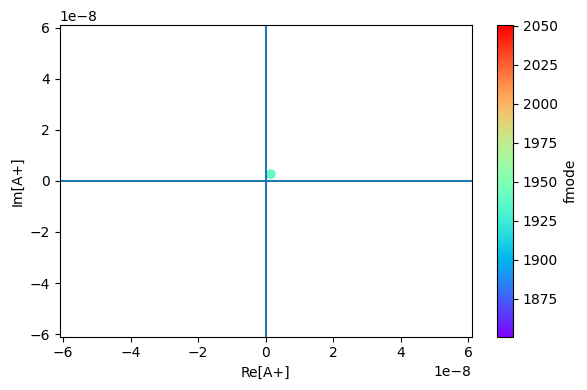

1944.2885771543088
Search Successful!
Fmode = 1944Hz


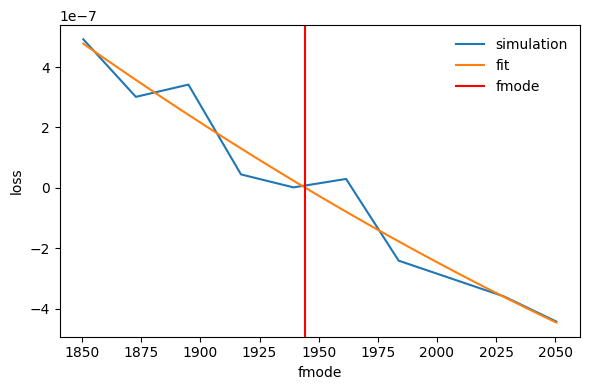

3006.4036309426538 1944.404913503755
1944.2885771543088


In [16]:
hw = hw2
fmin = fguess-hw
fmax = fguess+hw

for_loop = tqdm(np.linspace(fmin*2*np.pi + imag, fmax*2*np.pi + imag, 10))
# for_loop = tqdm([2.591e3 * 2 * np.pi + imag, 2.591e3 * 2 * np.pi + imag, 2.591e3 * 2 * np.pi + imag])

omega_vals = []
loss_vals = []
abs_loss_vals = []

for omega in for_loop:

    p_c, e_c, m0, omega, l, nl, nu0, Q0, b0, W0, K0, X0, H00, H10, init_VEC, \
    p_max, p_min, r_i, p0, e0 = initial_conditions(EOS, e_arr, p_arr, index, omega)

    p, m, r_arr, nu, h1, k, w, x = tov(EOS, init_VEC, r_i, p_min,p_max, 
                               omega, nl, progress = False, l = l, 
                                       n_iter_max = 20000 * 10)

    max_idx, m_R, r_R, p_R, ec_R, nu_R, h1_R, k_R, w_R, x_R, schild, \
    interior = surface_conditions(p, m, r_arr, nu, h1, k, w, x)

    # Update init_VEC
    nu_ext = -lamba_metric(m_R, r_R)
    nu_int = nu_R #At surface
    delta_nu = nu_int - nu_ext
    nu0 =  nu0 - delta_nu

    X0, H00, H10 = initial_conditions_helper(K0, e_c, p_c, nu0, omega, W0, nl, l, p0, e0)
    init_VEC = [p_c, m0, nu0, H10, K0, W0, X0]
    time.sleep(0.2)

    p, m, r_arr, nu, h1, k, w, x = tov(EOS, init_VEC, r_i, p_min,p_max, 
                               omega, nl, progress = False, l = l)

    max_idx, m_R, r_R, p_R, ec_R, nu_R, h1_R, k_R, w_R, x_R, schild, \
    interior = surface_conditions(p, m, r_arr, nu, h1, k, w, x)

    # Update init_VEC
    nu_ext = -lamba_metric(m_R, r_R)
    nu_int = nu_R #At surface
    delta_nu = nu_int - nu_ext
    nu0 =  nu0 - delta_nu

    X0, H00, H10 = initial_conditions_helper(K0, e_c, p_c, nu0, omega, W0, nl, l, p0, e0)
    init_VEC = [p_c, m0, nu0, H10, K0, W0, X0]
    time.sleep(0.2)

    p, m, r_arr, nu, h1, k, w, x = tov(EOS, init_VEC, r_i, p_min,p_max, 
                               omega, nl, progress = False, l = l)

    max_idx, m_R, r_R, p_R, ec_R, nu_R, h1_R, k_R, w_R, x_R, schild, \
    interior = surface_conditions(p, m, r_arr, nu, h1, k, w, x)

    
    if r_R < 3*km2cm:
        print(f"[ERROR] Radius is only {r_R/km2cm}km. Skipping...")
        continue

    def optimize_x_R(K0):

        # Update Initial Conditions in terms of K0    
        X0, H00, H10 = initial_conditions_helper(K0, e_c, p_c, nu0, omega, W0, nl, l, p0, e0)
        init_VEC = np.array([p_c, m0, nu0, H10, K0, W0, X0], dtype = complex).flatten()
        p, m, r_arr, nu, h1, k, w, x = tov(EOS, init_VEC, r_i, p_min,p_max, 
                                           omega, nl, progress = False, l = l, n_iter_max = 20000)
        max_idx, m_R, r_R, p_R, ec_R, nu_R, h1_R, k_R, w_R, x_R, schild, \
        interior = surface_conditions(p, m, r_arr, nu, h1, k, w, x)
        loss = np.log10(abs(x_R)) # Absolute loss of complex B.C.
        return loss

    K0_guess = K0
    init_guess = [K0_guess]
    res = minimize(optimize_x_R, x0 = init_guess, method='Nelder-Mead', 
                   options = {"disp": True, "maxiter":20, "fatol": 1e-20})


    K0 = res.x[0]
    X0_factor = (e_c + p_c) * np.exp(nu0/2)
    X0_term1 = 4 * np.pi/3 * (e_c + 3*p_c) * W0 * G/(c**4)
    X0_term2 = -(omega**2)/l * np.exp(-nu0) * W0  /(c**2)
    X0_term3 = K0/2
    X0 = X0_factor * (X0_term1 + X0_term2 + X0_term3)
    H00 = K0
    H10 = (l*K0 + 8*np.pi*(G/(c**4))*(e_c+p_c)*W0)/((nl+1))

    init_VEC = [p_c, m0, nu0, H10, K0, W0, X0]
    time.sleep(0.2)

    p, m, r_arr, nu, h1, k, w, x = tov(EOS, init_VEC, r_i, p_min,p_max, 
                               omega, nl, progress = False, l = l)

    max_idx, m_R, r_R, p_R, ec_R, nu_R, h1_R, k_R, w_R, x_R, schild, \
    interior = surface_conditions(p, m, r_arr, nu, h1, k, w, x)
    

    
    h1r = h1_R
    Kr = k_R
    b = _b(r_R, m_R)
    n = nl
    r = r_R
    z_R = r*(Kr/(1 - 2*b) - h1r)/(-(-3*b**2 - 3*b*n + n)/((1 - 2*b)*(3*b + n)) + (6*b**2 + 3*b*n + n*(n + 1))/((1 - 2*b)*(3*b + n)))
    dzdR_R = (-Kr*(-3*b**2 - 3*b*n + n)/((1 - 2*b)*(3*b + n)) + h1r*(6*b**2 + 3*b*n + n*(n + 1))/(3*b + n))/(-(-3*b**2 - 3*b*n + n)/((1 - 2*b)*(3*b + n)) + (6*b**2 + 3*b*n + n*(n + 1))/((1 - 2*b)*(3*b + n)))
    z0 = [z_R, dzdR_R]
#     print(z0, r_R)

    alpha0, alpha1, alpha2 = alphas(omega, nl, m_R)
    # From surface to inf
    r_vals = np.linspace(r_R, 25 * c / np.real(omega), 500)
    r_star_vals = r_star_func(r_vals, np.real(m_R))
    z, dzdr_star, r_int = zrly(omega, r_star_vals, progress = False)
    # Save final values
    zFinal = z[-1]
    zPrimeFinal = dzdr_star[-1]
    rFinal = r_vals[-1]
    rStarFinal = r_star_vals[-1]

    b = _b(rFinal, m_R)
    
    
    # Z+/-
    zMinus = np.exp(-1j*(omega/c)*rStarFinal) * (alpha0 + alpha1/rFinal + alpha2/(rFinal**2))
    zPlus = np.conjugate(zMinus)

    # Zprime +/-
    zPrimeMinus = -1j*(omega/c)*np.exp(-1j*(omega/c)*rStarFinal) \
                * (alpha0 + alpha1/rFinal + (alpha2 + 1j*alpha1*(1-2*b)*c/omega)/(rFinal**2))
    zPrimePlus = np.conjugate(zPrimeMinus)

    # A+
    A_plus = -zFinal*zPrimeMinus/(zMinus*zPrimePlus - zPlus*zPrimeMinus) \
            + zMinus*zPrimeFinal/(zMinus*zPrimePlus - zPlus*zPrimeMinus)

    # A-
    A_minus = -zFinal*zPrimePlus/(-zMinus*zPrimePlus + zPlus*zPrimeMinus) \
             + zPlus*zPrimeFinal/(-zMinus*zPrimePlus + zPlus*zPrimeMinus)

    loss = A_plus
    abs_loss = abs(loss)
    
    if abs_loss > 1e3:
        continue
        
    omega_vals.append(omega)
    loss_vals.append(loss)
    abs_loss_vals.append(abs_loss)

omega_arr = np.array(omega_vals)
loss_arr = np.array(loss_vals)
abs_loss_arr = np.array(abs_loss_vals)
fmode_arr = np.real(omega_arr/(2*np.pi))

plt.figure(dpi = 100)
sc = plt.scatter(np.real(loss_arr),np.imag(loss_arr), c = 
                 fmode_arr, cmap = cm.rainbow)
plt.xlabel("Re[A+]")
plt.ylabel("Im[A+]")
plt.colorbar(sc, label = "fmode")
plt.tight_layout()
plt.axhline(0)
plt.axvline(0)
lim = 20*min(np.abs(loss_arr))
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
plt.show()

def quadratic(x, a, b, c):
    return a*(x**2)+b*(x)+c

vec = np.real(loss_arr)
popt, pcov = curve_fit(quadratic, xdata = np.real(fmode_arr), ydata = vec)
f_arr = np.linspace(fmin*2*np.pi + imag, fmax*2*np.pi + imag, 500)/(2*np.pi)
fmode = np.real(f_arr[np.argmin(np.abs(quadratic(np.real(f_arr), *popt)))])
print(fmode)

if np.isclose(np.real(fmode), min(np.real(fmode_arr))) or np.isclose(np.real(fmode), max(np.real(fmode_arr))):
    print("Search Failed")
else:
    print(f"Search Successful!\nFmode = {round(fmode)}Hz")

_math_a,_math_b,_math_c = popt
det = np.sqrt(_math_b**2 - 4*_math_a*_math_c)
fmode1 = (-_math_b + det)/(2*_math_a)
fmode2 = (-_math_b - det)/(2*_math_a)

if abs(fmode1 - fmode2)<250:
    fmode = (fmode1 + fmode2)/2
    
plt.figure(dpi = 100)
plt.plot(np.real(fmode_arr), vec, label = "simulation")
plt.plot(np.real(f_arr), quadratic(np.real(f_arr), *popt), label = "fit")
plt.axvline(fmode, label = "fmode", color = "red")
plt.xlabel("fmode")
plt.ylabel("loss")
plt.legend()
plt.show()


print(fmode1, fmode2)
print(fmode)

fguess = fmode
    # print(np.array([h1[0], -k[0], x[0], w[0]]))

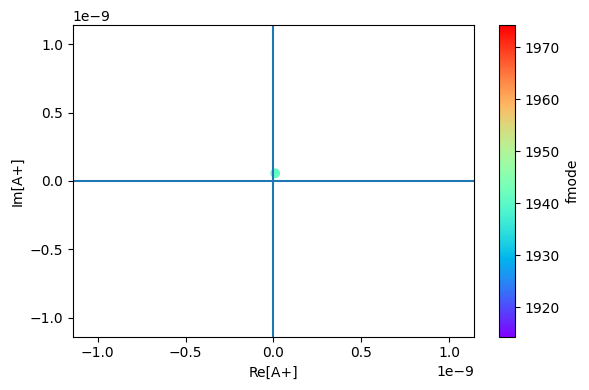

1949.7595190380764
Search Successful!
Fmode = 1950Hz


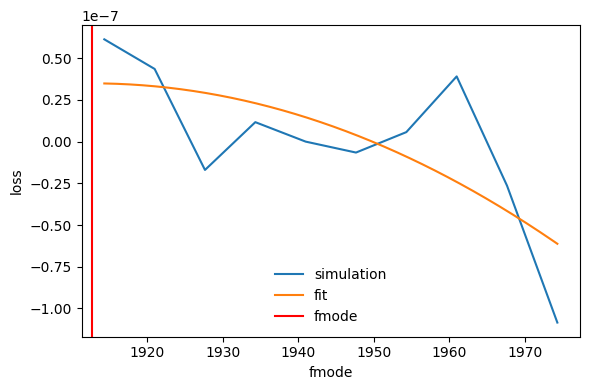

1875.4089362334273 1949.785754071718
1912.5973451525726


In [17]:
hw = hw3
fmin = fguess-hw
fmax = fguess+hw

for_loop = tqdm(np.linspace(fmin*2*np.pi + imag, fmax*2*np.pi + imag, 10))
# for_loop = tqdm([2.591e3 * 2 * np.pi + imag, 2.591e3 * 2 * np.pi + imag, 2.591e3 * 2 * np.pi + imag])

omega_vals = []
loss_vals = []
abs_loss_vals = []

for omega in for_loop:

    p_c, e_c, m0, omega, l, nl, nu0, Q0, b0, W0, K0, X0, H00, H10, init_VEC, \
    p_max, p_min, r_i, p0, e0 = initial_conditions(EOS, e_arr, p_arr, index, omega)

    p, m, r_arr, nu, h1, k, w, x = tov(EOS, init_VEC, r_i, p_min,p_max, 
                               omega, nl, progress = False, l = l, 
                                       n_iter_max = 20000 * 10)

    max_idx, m_R, r_R, p_R, ec_R, nu_R, h1_R, k_R, w_R, x_R, schild, \
    interior = surface_conditions(p, m, r_arr, nu, h1, k, w, x)

    # Update init_VEC
    nu_ext = -lamba_metric(m_R, r_R)
    nu_int = nu_R #At surface
    delta_nu = nu_int - nu_ext
    nu0 =  nu0 - delta_nu

    X0, H00, H10 = initial_conditions_helper(K0, e_c, p_c, nu0, omega, W0, nl, l, p0, e0)
    init_VEC = [p_c, m0, nu0, H10, K0, W0, X0]
    time.sleep(0.2)

    p, m, r_arr, nu, h1, k, w, x = tov(EOS, init_VEC, r_i, p_min,p_max, 
                               omega, nl, progress = False, l = l)

    max_idx, m_R, r_R, p_R, ec_R, nu_R, h1_R, k_R, w_R, x_R, schild, \
    interior = surface_conditions(p, m, r_arr, nu, h1, k, w, x)

    # Update init_VEC
    nu_ext = -lamba_metric(m_R, r_R)
    nu_int = nu_R #At surface
    delta_nu = nu_int - nu_ext
    nu0 =  nu0 - delta_nu

    X0, H00, H10 = initial_conditions_helper(K0, e_c, p_c, nu0, omega, W0, nl, l, p0, e0)
    init_VEC = [p_c, m0, nu0, H10, K0, W0, X0]
    time.sleep(0.2)

    p, m, r_arr, nu, h1, k, w, x = tov(EOS, init_VEC, r_i, p_min,p_max, 
                               omega, nl, progress = False, l = l)

    max_idx, m_R, r_R, p_R, ec_R, nu_R, h1_R, k_R, w_R, x_R, schild, \
    interior = surface_conditions(p, m, r_arr, nu, h1, k, w, x)

    
    if r_R < 3*km2cm:
        print(f"[ERROR] Radius is only {r_R/km2cm}km. Skipping...")
        continue

    def optimize_x_R(K0):

        # Update Initial Conditions in terms of K0    
        X0, H00, H10 = initial_conditions_helper(K0, e_c, p_c, nu0, omega, W0, nl, l, p0, e0)
        init_VEC = np.array([p_c, m0, nu0, H10, K0, W0, X0], dtype = complex).flatten()
        p, m, r_arr, nu, h1, k, w, x = tov(EOS, init_VEC, r_i, p_min,p_max, 
                                           omega, nl, progress = False, l = l, n_iter_max = 20000)
        max_idx, m_R, r_R, p_R, ec_R, nu_R, h1_R, k_R, w_R, x_R, schild, \
        interior = surface_conditions(p, m, r_arr, nu, h1, k, w, x)
        loss = np.log10(abs(x_R)) # Absolute loss of complex B.C.
        return loss

    K0_guess = K0
    init_guess = [K0_guess]
    res = minimize(optimize_x_R, x0 = init_guess, method='Nelder-Mead', 
                   options = {"disp": True, "maxiter":20, "fatol": 1e-20})


    K0 = res.x[0]
    X0_factor = (e_c + p_c) * np.exp(nu0/2)
    X0_term1 = 4 * np.pi/3 * (e_c + 3*p_c) * W0 * G/(c**4)
    X0_term2 = -(omega**2)/l * np.exp(-nu0) * W0  /(c**2)
    X0_term3 = K0/2
    X0 = X0_factor * (X0_term1 + X0_term2 + X0_term3)
    H00 = K0
    H10 = (l*K0 + 8*np.pi*(G/(c**4))*(e_c+p_c)*W0)/((nl+1))

    init_VEC = [p_c, m0, nu0, H10, K0, W0, X0]
    time.sleep(0.2)

    p, m, r_arr, nu, h1, k, w, x = tov(EOS, init_VEC, r_i, p_min,p_max, 
                               omega, nl, progress = False, l = l)

    max_idx, m_R, r_R, p_R, ec_R, nu_R, h1_R, k_R, w_R, x_R, schild, \
    interior = surface_conditions(p, m, r_arr, nu, h1, k, w, x)
    

    
    h1r = h1_R
    Kr = k_R
    b = _b(r_R, m_R)
    n = nl
    r = r_R
    z_R = r*(Kr/(1 - 2*b) - h1r)/(-(-3*b**2 - 3*b*n + n)/((1 - 2*b)*(3*b + n)) + (6*b**2 + 3*b*n + n*(n + 1))/((1 - 2*b)*(3*b + n)))
    dzdR_R = (-Kr*(-3*b**2 - 3*b*n + n)/((1 - 2*b)*(3*b + n)) + h1r*(6*b**2 + 3*b*n + n*(n + 1))/(3*b + n))/(-(-3*b**2 - 3*b*n + n)/((1 - 2*b)*(3*b + n)) + (6*b**2 + 3*b*n + n*(n + 1))/((1 - 2*b)*(3*b + n)))
    z0 = [z_R, dzdR_R]
#     print(z0, r_R)

    alpha0, alpha1, alpha2 = alphas(omega, nl, m_R)
    # From surface to inf
    r_vals = np.linspace(r_R, 25 * c / np.real(omega), 500)
    r_star_vals = r_star_func(r_vals, np.real(m_R))
    z, dzdr_star, r_int = zrly(omega, r_star_vals, progress = False)
    # Save final values
    zFinal = z[-1]
    zPrimeFinal = dzdr_star[-1]
    rFinal = r_vals[-1]
    rStarFinal = r_star_vals[-1]

    b = _b(rFinal, m_R)
    
    
    # Z+/-
    zMinus = np.exp(-1j*(omega/c)*rStarFinal) * (alpha0 + alpha1/rFinal + alpha2/(rFinal**2))
    zPlus = np.conjugate(zMinus)

    # Zprime +/-
    zPrimeMinus = -1j*(omega/c)*np.exp(-1j*(omega/c)*rStarFinal) \
                * (alpha0 + alpha1/rFinal + (alpha2 + 1j*alpha1*(1-2*b)*c/omega)/(rFinal**2))
    zPrimePlus = np.conjugate(zPrimeMinus)

    # A+
    A_plus = -zFinal*zPrimeMinus/(zMinus*zPrimePlus - zPlus*zPrimeMinus) \
            + zMinus*zPrimeFinal/(zMinus*zPrimePlus - zPlus*zPrimeMinus)

    # A-
    A_minus = -zFinal*zPrimePlus/(-zMinus*zPrimePlus + zPlus*zPrimeMinus) \
             + zPlus*zPrimeFinal/(-zMinus*zPrimePlus + zPlus*zPrimeMinus)

    loss = A_plus
    abs_loss = abs(loss)
    
    if abs_loss > 1e3:
        continue
        
    omega_vals.append(omega)
    loss_vals.append(loss)
    abs_loss_vals.append(abs_loss)

omega_arr = np.array(omega_vals)
loss_arr = np.array(loss_vals)
abs_loss_arr = np.array(abs_loss_vals)
fmode_arr = np.real(omega_arr/(2*np.pi))

plt.figure(dpi = 100)
sc = plt.scatter(np.real(loss_arr),np.imag(loss_arr), c = 
                 fmode_arr, cmap = cm.rainbow)
plt.xlabel("Re[A+]")
plt.ylabel("Im[A+]")
plt.colorbar(sc, label = "fmode")
plt.tight_layout()
plt.axhline(0)
plt.axvline(0)
lim = 20*min(np.abs(loss_arr))
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
plt.show()

def quadratic(x, a, b, c):
    return a*(x**2)+b*(x)+c

vec = np.real(loss_arr)
popt, pcov = curve_fit(quadratic, xdata = np.real(fmode_arr), ydata = vec)
f_arr = np.linspace(fmin*2*np.pi + imag, fmax*2*np.pi + imag, 500)/(2*np.pi)
fmode = np.real(f_arr[np.argmin(np.abs(quadratic(np.real(f_arr), *popt)))])
print(fmode)

if np.isclose(np.real(fmode), min(np.real(fmode_arr))) or np.isclose(np.real(fmode), max(np.real(fmode_arr))):
    print("Search Failed")
else:
    print(f"Search Successful!\nFmode = {round(fmode)}Hz")

_math_a,_math_b,_math_c = popt
det = np.sqrt(_math_b**2 - 4*_math_a*_math_c)
fmode1 = (-_math_b + det)/(2*_math_a)
fmode2 = (-_math_b - det)/(2*_math_a)

if abs(fmode1 - fmode2)<250:
    fmode = (fmode1 + fmode2)/2
    
plt.figure(dpi = 100)
plt.plot(np.real(fmode_arr), vec, label = "simulation")
plt.plot(np.real(f_arr), quadratic(np.real(f_arr), *popt), label = "fit")
plt.axvline(fmode, label = "fmode", color = "red")
plt.xlabel("fmode")
plt.ylabel("loss")
plt.legend()
plt.show()


print(fmode1, fmode2)
print(fmode)

fguess = fmode
    # print(np.array([h1[0], -k[0], x[0], w[0]]))

## Solar Mass

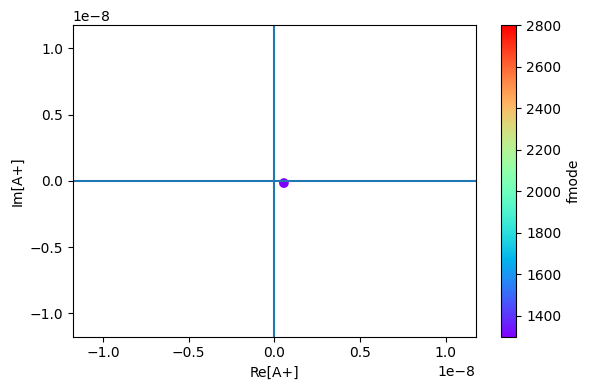

1300.0
Search Failed


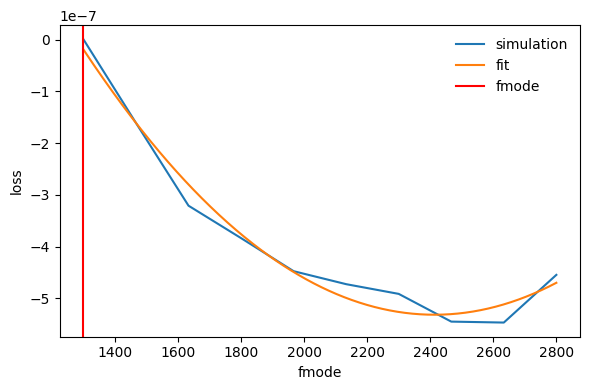

3547.6479527446418 1279.45852799295
1300.0


In [18]:
# NL3
# index = -660
index = -1028


# SLY230A
# index = -16
# index = -71

# SLY4
# index = -27
# index = -91

imag = 5j
# omega = 1.932e3 * 2 * np.pi + imag
fmin = 2.8e3
fmax = 1.3e3

for_loop = tqdm(np.linspace(fmin*2*np.pi + imag, fmax*2*np.pi + imag, 10))
# for_loop = tqdm([2.591e3 * 2 * np.pi + imag, 2.591e3 * 2 * np.pi + imag, 2.591e3 * 2 * np.pi + imag])

omega_vals = []
loss_vals = []
abs_loss_vals = []

for omega in for_loop:

    p_c, e_c, m0, omega, l, nl, nu0, Q0, b0, W0, K0, X0, H00, H10, init_VEC, \
    p_max, p_min, r_i, p0, e0 = initial_conditions(EOS, e_arr, p_arr, index, omega)

    p, m, r_arr, nu, h1, k, w, x = tov(EOS, init_VEC, r_i, p_min,p_max, 
                               omega, nl, progress = False, l = l, 
                                       n_iter_max = 20000 * 10)

    max_idx, m_R, r_R, p_R, ec_R, nu_R, h1_R, k_R, w_R, x_R, schild, \
    interior = surface_conditions(p, m, r_arr, nu, h1, k, w, x)

    # Update init_VEC
    nu_ext = -lamba_metric(m_R, r_R)
    nu_int = nu_R #At surface
    delta_nu = nu_int - nu_ext
    nu0 =  nu0 - delta_nu

    X0, H00, H10 = initial_conditions_helper(K0, e_c, p_c, nu0, omega, W0, nl, l, p0, e0)
    init_VEC = [p_c, m0, nu0, H10, K0, W0, X0]
    time.sleep(0.2)

    p, m, r_arr, nu, h1, k, w, x = tov(EOS, init_VEC, r_i, p_min,p_max, 
                               omega, nl, progress = False, l = l)

    max_idx, m_R, r_R, p_R, ec_R, nu_R, h1_R, k_R, w_R, x_R, schild, \
    interior = surface_conditions(p, m, r_arr, nu, h1, k, w, x)

    # Update init_VEC
    nu_ext = -lamba_metric(m_R, r_R)
    nu_int = nu_R #At surface
    delta_nu = nu_int - nu_ext
    nu0 =  nu0 - delta_nu

    X0, H00, H10 = initial_conditions_helper(K0, e_c, p_c, nu0, omega, W0, nl, l, p0, e0)
    init_VEC = [p_c, m0, nu0, H10, K0, W0, X0]
    time.sleep(0.2)

    p, m, r_arr, nu, h1, k, w, x = tov(EOS, init_VEC, r_i, p_min,p_max, 
                               omega, nl, progress = False, l = l)

    max_idx, m_R, r_R, p_R, ec_R, nu_R, h1_R, k_R, w_R, x_R, schild, \
    interior = surface_conditions(p, m, r_arr, nu, h1, k, w, x)

    
    if r_R < 3*km2cm:
        print(f"[ERROR] Radius is only {r_R/km2cm}km. Skipping...")
        continue

    def optimize_x_R(K0):

        # Update Initial Conditions in terms of K0    
        X0, H00, H10 = initial_conditions_helper(K0, e_c, p_c, nu0, omega, W0, nl, l, p0, e0)
        init_VEC = np.array([p_c, m0, nu0, H10, K0, W0, X0], dtype = complex).flatten()
        p, m, r_arr, nu, h1, k, w, x = tov(EOS, init_VEC, r_i, p_min,p_max, 
                                           omega, nl, progress = False, l = l, n_iter_max = 20000)
        max_idx, m_R, r_R, p_R, ec_R, nu_R, h1_R, k_R, w_R, x_R, schild, \
        interior = surface_conditions(p, m, r_arr, nu, h1, k, w, x)
        loss = np.log10(abs(x_R)) # Absolute loss of complex B.C.
        return loss

    K0_guess = K0
    init_guess = [K0_guess]
    res = minimize(optimize_x_R, x0 = init_guess, method='Nelder-Mead', 
                   options = {"disp": True, "maxiter":20, "fatol": 1e-20})


    K0 = res.x[0]
    X0_factor = (e_c + p_c) * np.exp(nu0/2)
    X0_term1 = 4 * np.pi/3 * (e_c + 3*p_c) * W0 * G/(c**4)
    X0_term2 = -(omega**2)/l * np.exp(-nu0) * W0  /(c**2)
    X0_term3 = K0/2
    X0 = X0_factor * (X0_term1 + X0_term2 + X0_term3)
    H00 = K0
    H10 = (l*K0 + 8*np.pi*(G/(c**4))*(e_c+p_c)*W0)/((nl+1))

    init_VEC = [p_c, m0, nu0, H10, K0, W0, X0]
    time.sleep(0.2)

    p, m, r_arr, nu, h1, k, w, x = tov(EOS, init_VEC, r_i, p_min,p_max, 
                               omega, nl, progress = False, l = l)

    max_idx, m_R, r_R, p_R, ec_R, nu_R, h1_R, k_R, w_R, x_R, schild, \
    interior = surface_conditions(p, m, r_arr, nu, h1, k, w, x)
    

    
    h1r = h1_R
    Kr = k_R
    b = _b(r_R, m_R)
    n = nl
    r = r_R
    z_R = r*(Kr/(1 - 2*b) - h1r)/(-(-3*b**2 - 3*b*n + n)/((1 - 2*b)*(3*b + n)) + (6*b**2 + 3*b*n + n*(n + 1))/((1 - 2*b)*(3*b + n)))
    dzdR_R = (-Kr*(-3*b**2 - 3*b*n + n)/((1 - 2*b)*(3*b + n)) + h1r*(6*b**2 + 3*b*n + n*(n + 1))/(3*b + n))/(-(-3*b**2 - 3*b*n + n)/((1 - 2*b)*(3*b + n)) + (6*b**2 + 3*b*n + n*(n + 1))/((1 - 2*b)*(3*b + n)))
    z0 = [z_R, dzdR_R]
#     print(z0, r_R)

    alpha0, alpha1, alpha2 = alphas(omega, nl, m_R)
    # From surface to inf
    r_vals = np.linspace(r_R, 25 * c / np.real(omega), 500)
    r_star_vals = r_star_func(r_vals, np.real(m_R))
    z, dzdr_star, r_int = zrly(omega, r_star_vals, progress = False)
    # Save final values
    zFinal = z[-1]
    zPrimeFinal = dzdr_star[-1]
    rFinal = r_vals[-1]
    rStarFinal = r_star_vals[-1]

    b = _b(rFinal, m_R)
    
    
    # Z+/-
    zMinus = np.exp(-1j*(omega/c)*rStarFinal) * (alpha0 + alpha1/rFinal + alpha2/(rFinal**2))
    zPlus = np.conjugate(zMinus)

    # Zprime +/-
    zPrimeMinus = -1j*(omega/c)*np.exp(-1j*(omega/c)*rStarFinal) \
                * (alpha0 + alpha1/rFinal + (alpha2 + 1j*alpha1*(1-2*b)*c/omega)/(rFinal**2))
    zPrimePlus = np.conjugate(zPrimeMinus)

    # A+
    A_plus = -zFinal*zPrimeMinus/(zMinus*zPrimePlus - zPlus*zPrimeMinus) \
            + zMinus*zPrimeFinal/(zMinus*zPrimePlus - zPlus*zPrimeMinus)

    # A-
    A_minus = -zFinal*zPrimePlus/(-zMinus*zPrimePlus + zPlus*zPrimeMinus) \
             + zPlus*zPrimeFinal/(-zMinus*zPrimePlus + zPlus*zPrimeMinus)

    loss = A_plus
    abs_loss = abs(loss)
    
    if abs_loss > 1e3:
        continue
        
    omega_vals.append(omega)
    loss_vals.append(loss)
    abs_loss_vals.append(abs_loss)

omega_arr = np.array(omega_vals)
loss_arr = np.array(loss_vals)
abs_loss_arr = np.array(abs_loss_vals)
fmode_arr = np.real(omega_arr/(2*np.pi))

plt.figure(dpi = 100)
sc = plt.scatter(np.real(loss_arr),np.imag(loss_arr), c = 
                 fmode_arr, cmap = cm.rainbow)
plt.xlabel("Re[A+]")
plt.ylabel("Im[A+]")
plt.colorbar(sc, label = "fmode")
plt.tight_layout()
plt.axhline(0)
plt.axvline(0)
lim = 20*min(np.abs(loss_arr))
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
plt.show()

def quadratic(x, a, b, c):
    return a*(x**2)+b*(x)+c

vec = np.real(loss_arr)
popt, pcov = curve_fit(quadratic, xdata = np.real(fmode_arr), ydata = vec)
f_arr = np.linspace(fmin*2*np.pi + imag, fmax*2*np.pi + imag, 500)/(2*np.pi)
fmode = np.real(f_arr[np.argmin(np.abs(quadratic(np.real(f_arr), *popt)))])
print(fmode)

if np.isclose(np.real(fmode), min(np.real(fmode_arr))) or np.isclose(np.real(fmode), max(np.real(fmode_arr))):
    print("Search Failed")
else:
    print(f"Search Successful!\nFmode = {round(fmode)}Hz")

_math_a,_math_b,_math_c = popt
det = np.sqrt(_math_b**2 - 4*_math_a*_math_c)
fmode1 = (-_math_b + det)/(2*_math_a)
fmode2 = (-_math_b - det)/(2*_math_a)

if abs(fmode1 - fmode2)<250:
    fmode = (fmode1 + fmode2)/2
    
plt.figure(dpi = 100)
plt.plot(np.real(fmode_arr), vec, label = "simulation")
plt.plot(np.real(f_arr), quadratic(np.real(f_arr), *popt), label = "fit")
plt.axvline(fmode, label = "fmode", color = "red")
plt.xlabel("fmode")
plt.ylabel("loss")
plt.legend()
plt.show()


print(fmode1, fmode2)
print(fmode)

fguess = fmode
    # print(np.array([h1[0], -k[0], x[0], w[0]]))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/integrate/_ode.py:1011: UserWarning: vode: Excess work done on this call. (Perhaps wrong MF.)
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


[ERROR] Radius is only 1e-05km. Skipping...
[ERROR] Radius is only 1e-05km. Skipping...
[ERROR] Radius is only 1e-05km. Skipping...



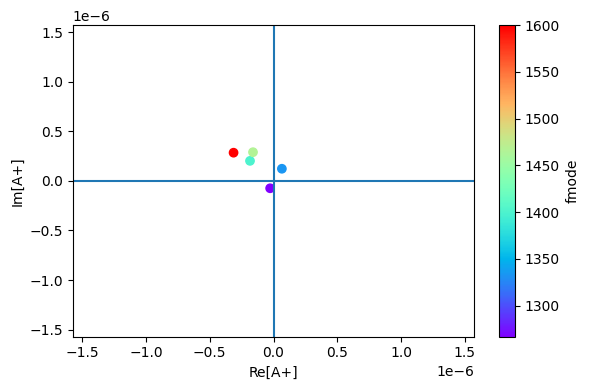

1283.7675350701404
Search Successful!
Fmode = 1284Hz


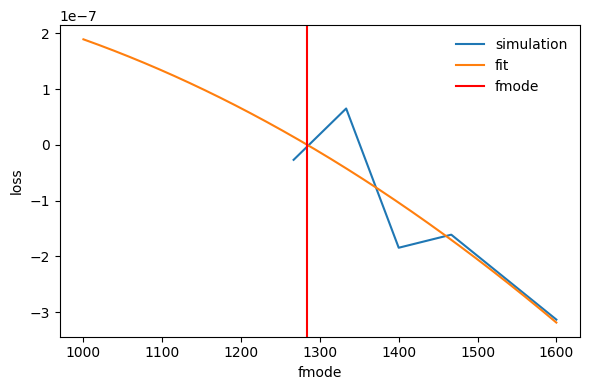

-167.24817903257804 1284.2314680113407
1283.7675350701404


In [19]:
hw = hw1
fmin = fguess-hw
fmax = fguess+hw

for_loop = tqdm(np.linspace(fmin*2*np.pi + imag, fmax*2*np.pi + imag, 10))
# for_loop = tqdm([2.591e3 * 2 * np.pi + imag, 2.591e3 * 2 * np.pi + imag, 2.591e3 * 2 * np.pi + imag])

omega_vals = []
loss_vals = []
abs_loss_vals = []

for omega in for_loop:

    p_c, e_c, m0, omega, l, nl, nu0, Q0, b0, W0, K0, X0, H00, H10, init_VEC, \
    p_max, p_min, r_i, p0, e0 = initial_conditions(EOS, e_arr, p_arr, index, omega)

    p, m, r_arr, nu, h1, k, w, x = tov(EOS, init_VEC, r_i, p_min,p_max, 
                               omega, nl, progress = False, l = l, 
                                       n_iter_max = 20000 * 10)

    max_idx, m_R, r_R, p_R, ec_R, nu_R, h1_R, k_R, w_R, x_R, schild, \
    interior = surface_conditions(p, m, r_arr, nu, h1, k, w, x)

    # Update init_VEC
    nu_ext = -lamba_metric(m_R, r_R)
    nu_int = nu_R #At surface
    delta_nu = nu_int - nu_ext
    nu0 =  nu0 - delta_nu

    X0, H00, H10 = initial_conditions_helper(K0, e_c, p_c, nu0, omega, W0, nl, l, p0, e0)
    init_VEC = [p_c, m0, nu0, H10, K0, W0, X0]
    time.sleep(0.2)

    p, m, r_arr, nu, h1, k, w, x = tov(EOS, init_VEC, r_i, p_min,p_max, 
                               omega, nl, progress = False, l = l)

    max_idx, m_R, r_R, p_R, ec_R, nu_R, h1_R, k_R, w_R, x_R, schild, \
    interior = surface_conditions(p, m, r_arr, nu, h1, k, w, x)

    # Update init_VEC
    nu_ext = -lamba_metric(m_R, r_R)
    nu_int = nu_R #At surface
    delta_nu = nu_int - nu_ext
    nu0 =  nu0 - delta_nu

    X0, H00, H10 = initial_conditions_helper(K0, e_c, p_c, nu0, omega, W0, nl, l, p0, e0)
    init_VEC = [p_c, m0, nu0, H10, K0, W0, X0]
    time.sleep(0.2)

    p, m, r_arr, nu, h1, k, w, x = tov(EOS, init_VEC, r_i, p_min,p_max, 
                               omega, nl, progress = False, l = l)

    max_idx, m_R, r_R, p_R, ec_R, nu_R, h1_R, k_R, w_R, x_R, schild, \
    interior = surface_conditions(p, m, r_arr, nu, h1, k, w, x)

    
    if r_R < 3*km2cm:
        print(f"[ERROR] Radius is only {r_R/km2cm}km. Skipping...")
        continue

    def optimize_x_R(K0):

        # Update Initial Conditions in terms of K0    
        X0, H00, H10 = initial_conditions_helper(K0, e_c, p_c, nu0, omega, W0, nl, l, p0, e0)
        init_VEC = np.array([p_c, m0, nu0, H10, K0, W0, X0], dtype = complex).flatten()
        p, m, r_arr, nu, h1, k, w, x = tov(EOS, init_VEC, r_i, p_min,p_max, 
                                           omega, nl, progress = False, l = l, n_iter_max = 20000)
        max_idx, m_R, r_R, p_R, ec_R, nu_R, h1_R, k_R, w_R, x_R, schild, \
        interior = surface_conditions(p, m, r_arr, nu, h1, k, w, x)
        loss = np.log10(abs(x_R)) # Absolute loss of complex B.C.
        return loss

    K0_guess = K0
    init_guess = [K0_guess]
    res = minimize(optimize_x_R, x0 = init_guess, method='Nelder-Mead', 
                   options = {"disp": True, "maxiter":20, "fatol": 1e-20})


    K0 = res.x[0]
    X0_factor = (e_c + p_c) * np.exp(nu0/2)
    X0_term1 = 4 * np.pi/3 * (e_c + 3*p_c) * W0 * G/(c**4)
    X0_term2 = -(omega**2)/l * np.exp(-nu0) * W0  /(c**2)
    X0_term3 = K0/2
    X0 = X0_factor * (X0_term1 + X0_term2 + X0_term3)
    H00 = K0
    H10 = (l*K0 + 8*np.pi*(G/(c**4))*(e_c+p_c)*W0)/((nl+1))

    init_VEC = [p_c, m0, nu0, H10, K0, W0, X0]
    time.sleep(0.2)

    p, m, r_arr, nu, h1, k, w, x = tov(EOS, init_VEC, r_i, p_min,p_max, 
                               omega, nl, progress = False, l = l)

    max_idx, m_R, r_R, p_R, ec_R, nu_R, h1_R, k_R, w_R, x_R, schild, \
    interior = surface_conditions(p, m, r_arr, nu, h1, k, w, x)
    

    
    h1r = h1_R
    Kr = k_R
    b = _b(r_R, m_R)
    n = nl
    r = r_R
    z_R = r*(Kr/(1 - 2*b) - h1r)/(-(-3*b**2 - 3*b*n + n)/((1 - 2*b)*(3*b + n)) + (6*b**2 + 3*b*n + n*(n + 1))/((1 - 2*b)*(3*b + n)))
    dzdR_R = (-Kr*(-3*b**2 - 3*b*n + n)/((1 - 2*b)*(3*b + n)) + h1r*(6*b**2 + 3*b*n + n*(n + 1))/(3*b + n))/(-(-3*b**2 - 3*b*n + n)/((1 - 2*b)*(3*b + n)) + (6*b**2 + 3*b*n + n*(n + 1))/((1 - 2*b)*(3*b + n)))
    z0 = [z_R, dzdR_R]
#     print(z0, r_R)

    alpha0, alpha1, alpha2 = alphas(omega, nl, m_R)
    # From surface to inf
    r_vals = np.linspace(r_R, 25 * c / np.real(omega), 500)
    r_star_vals = r_star_func(r_vals, np.real(m_R))
    z, dzdr_star, r_int = zrly(omega, r_star_vals, progress = False)
    # Save final values
    zFinal = z[-1]
    zPrimeFinal = dzdr_star[-1]
    rFinal = r_vals[-1]
    rStarFinal = r_star_vals[-1]

    b = _b(rFinal, m_R)
    
    
    # Z+/-
    zMinus = np.exp(-1j*(omega/c)*rStarFinal) * (alpha0 + alpha1/rFinal + alpha2/(rFinal**2))
    zPlus = np.conjugate(zMinus)

    # Zprime +/-
    zPrimeMinus = -1j*(omega/c)*np.exp(-1j*(omega/c)*rStarFinal) \
                * (alpha0 + alpha1/rFinal + (alpha2 + 1j*alpha1*(1-2*b)*c/omega)/(rFinal**2))
    zPrimePlus = np.conjugate(zPrimeMinus)

    # A+
    A_plus = -zFinal*zPrimeMinus/(zMinus*zPrimePlus - zPlus*zPrimeMinus) \
            + zMinus*zPrimeFinal/(zMinus*zPrimePlus - zPlus*zPrimeMinus)

    # A-
    A_minus = -zFinal*zPrimePlus/(-zMinus*zPrimePlus + zPlus*zPrimeMinus) \
             + zPlus*zPrimeFinal/(-zMinus*zPrimePlus + zPlus*zPrimeMinus)

    loss = A_plus
    abs_loss = abs(loss)
    
    if abs_loss > 1e3:
        continue
    
    omega_vals.append(omega)
    loss_vals.append(loss)
    abs_loss_vals.append(abs_loss)

omega_arr = np.array(omega_vals)
loss_arr = np.array(loss_vals)
abs_loss_arr = np.array(abs_loss_vals)
fmode_arr = np.real(omega_arr/(2*np.pi))

plt.figure(dpi = 100)
sc = plt.scatter(np.real(loss_arr),np.imag(loss_arr), c = 
                 fmode_arr, cmap = cm.rainbow)
plt.xlabel("Re[A+]")
plt.ylabel("Im[A+]")
plt.colorbar(sc, label = "fmode")
plt.tight_layout()
plt.axhline(0)
plt.axvline(0)
lim = 20*min(np.abs(loss_arr))
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
plt.show()

def quadratic(x, a, b, c):
    return a*(x**2)+b*(x)+c

vec = np.real(loss_arr)
popt, pcov = curve_fit(quadratic, xdata = np.real(fmode_arr), ydata = vec)
f_arr = np.linspace(fmin*2*np.pi + imag, fmax*2*np.pi + imag, 500)/(2*np.pi)
fmode = np.real(f_arr[np.argmin(np.abs(quadratic(np.real(f_arr), *popt)))])
print(fmode)

if np.isclose(np.real(fmode), min(np.real(fmode_arr))) or np.isclose(np.real(fmode), max(np.real(fmode_arr))):
    print("Search Failed")
else:
    print(f"Search Successful!\nFmode = {round(fmode)}Hz")

_math_a,_math_b,_math_c = popt
det = np.sqrt(_math_b**2 - 4*_math_a*_math_c)
fmode1 = (-_math_b + det)/(2*_math_a)
fmode2 = (-_math_b - det)/(2*_math_a)

if abs(fmode1 - fmode2)<250:
    fmode = (fmode1 + fmode2)/2
    
plt.figure(dpi = 100)
plt.plot(np.real(fmode_arr), vec, label = "simulation")
plt.plot(np.real(f_arr), quadratic(np.real(f_arr), *popt), label = "fit")
plt.axvline(fmode, label = "fmode", color = "red")
plt.xlabel("fmode")
plt.ylabel("loss")
plt.legend()
plt.show()


print(fmode1, fmode2)
print(fmode)

fguess = fmode
    # print(np.array([h1[0], -k[0], x[0], w[0]]))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/integrate/_ode.py:1011: UserWarning: vode: Excess work done on this call. (Perhaps wrong MF.)
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


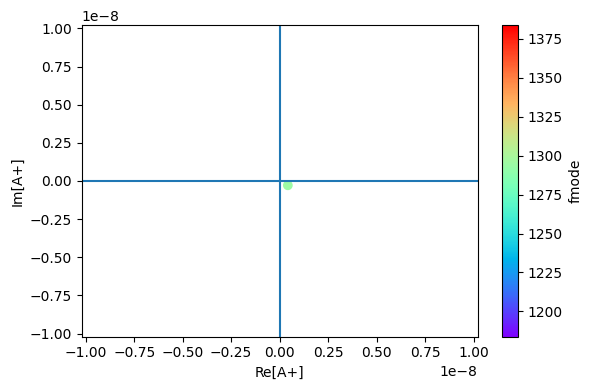

1300.8016032064131
Search Successful!
Fmode = 1301Hz


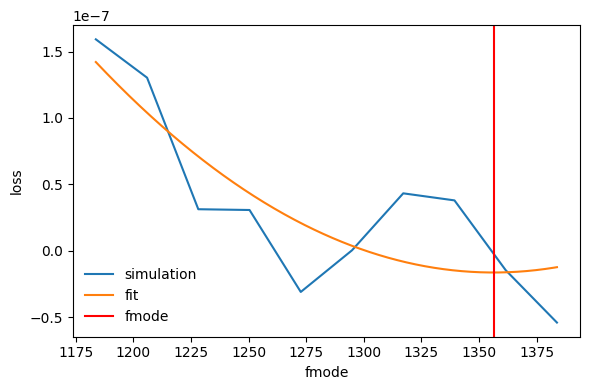

1411.641375342037 1300.998424653752
1356.3198999978945


In [20]:
hw = hw2
fmin = fguess-hw
fmax = fguess+hw

for_loop = tqdm(np.linspace(fmin*2*np.pi + imag, fmax*2*np.pi + imag, 10))
# for_loop = tqdm([2.591e3 * 2 * np.pi + imag, 2.591e3 * 2 * np.pi + imag, 2.591e3 * 2 * np.pi + imag])

omega_vals = []
loss_vals = []
abs_loss_vals = []

for omega in for_loop:

    p_c, e_c, m0, omega, l, nl, nu0, Q0, b0, W0, K0, X0, H00, H10, init_VEC, \
    p_max, p_min, r_i, p0, e0 = initial_conditions(EOS, e_arr, p_arr, index, omega)

    p, m, r_arr, nu, h1, k, w, x = tov(EOS, init_VEC, r_i, p_min,p_max, 
                               omega, nl, progress = False, l = l, 
                                       n_iter_max = 20000 * 10)

    max_idx, m_R, r_R, p_R, ec_R, nu_R, h1_R, k_R, w_R, x_R, schild, \
    interior = surface_conditions(p, m, r_arr, nu, h1, k, w, x)

    # Update init_VEC
    nu_ext = -lamba_metric(m_R, r_R)
    nu_int = nu_R #At surface
    delta_nu = nu_int - nu_ext
    nu0 =  nu0 - delta_nu

    X0, H00, H10 = initial_conditions_helper(K0, e_c, p_c, nu0, omega, W0, nl, l, p0, e0)
    init_VEC = [p_c, m0, nu0, H10, K0, W0, X0]
    time.sleep(0.2)

    p, m, r_arr, nu, h1, k, w, x = tov(EOS, init_VEC, r_i, p_min,p_max, 
                               omega, nl, progress = False, l = l)

    max_idx, m_R, r_R, p_R, ec_R, nu_R, h1_R, k_R, w_R, x_R, schild, \
    interior = surface_conditions(p, m, r_arr, nu, h1, k, w, x)

    # Update init_VEC
    nu_ext = -lamba_metric(m_R, r_R)
    nu_int = nu_R #At surface
    delta_nu = nu_int - nu_ext
    nu0 =  nu0 - delta_nu

    X0, H00, H10 = initial_conditions_helper(K0, e_c, p_c, nu0, omega, W0, nl, l, p0, e0)
    init_VEC = [p_c, m0, nu0, H10, K0, W0, X0]
    time.sleep(0.2)

    p, m, r_arr, nu, h1, k, w, x = tov(EOS, init_VEC, r_i, p_min,p_max, 
                               omega, nl, progress = False, l = l)

    max_idx, m_R, r_R, p_R, ec_R, nu_R, h1_R, k_R, w_R, x_R, schild, \
    interior = surface_conditions(p, m, r_arr, nu, h1, k, w, x)

    
    if r_R < 3*km2cm:
        print(f"[ERROR] Radius is only {r_R/km2cm}km. Skipping...")
        continue

    def optimize_x_R(K0):

        # Update Initial Conditions in terms of K0    
        X0, H00, H10 = initial_conditions_helper(K0, e_c, p_c, nu0, omega, W0, nl, l, p0, e0)
        init_VEC = np.array([p_c, m0, nu0, H10, K0, W0, X0], dtype = complex).flatten()
        p, m, r_arr, nu, h1, k, w, x = tov(EOS, init_VEC, r_i, p_min,p_max, 
                                           omega, nl, progress = False, l = l, n_iter_max = 20000)
        max_idx, m_R, r_R, p_R, ec_R, nu_R, h1_R, k_R, w_R, x_R, schild, \
        interior = surface_conditions(p, m, r_arr, nu, h1, k, w, x)
        loss = np.log10(abs(x_R)) # Absolute loss of complex B.C.
        return loss

    K0_guess = K0
    init_guess = [K0_guess]
    res = minimize(optimize_x_R, x0 = init_guess, method='Nelder-Mead', 
                   options = {"disp": True, "maxiter":20, "fatol": 1e-20})


    K0 = res.x[0]
    X0_factor = (e_c + p_c) * np.exp(nu0/2)
    X0_term1 = 4 * np.pi/3 * (e_c + 3*p_c) * W0 * G/(c**4)
    X0_term2 = -(omega**2)/l * np.exp(-nu0) * W0  /(c**2)
    X0_term3 = K0/2
    X0 = X0_factor * (X0_term1 + X0_term2 + X0_term3)
    H00 = K0
    H10 = (l*K0 + 8*np.pi*(G/(c**4))*(e_c+p_c)*W0)/((nl+1))

    init_VEC = [p_c, m0, nu0, H10, K0, W0, X0]
    time.sleep(0.2)

    p, m, r_arr, nu, h1, k, w, x = tov(EOS, init_VEC, r_i, p_min,p_max, 
                               omega, nl, progress = False, l = l)

    max_idx, m_R, r_R, p_R, ec_R, nu_R, h1_R, k_R, w_R, x_R, schild, \
    interior = surface_conditions(p, m, r_arr, nu, h1, k, w, x)
    

    
    h1r = h1_R
    Kr = k_R
    b = _b(r_R, m_R)
    n = nl
    r = r_R
    z_R = r*(Kr/(1 - 2*b) - h1r)/(-(-3*b**2 - 3*b*n + n)/((1 - 2*b)*(3*b + n)) + (6*b**2 + 3*b*n + n*(n + 1))/((1 - 2*b)*(3*b + n)))
    dzdR_R = (-Kr*(-3*b**2 - 3*b*n + n)/((1 - 2*b)*(3*b + n)) + h1r*(6*b**2 + 3*b*n + n*(n + 1))/(3*b + n))/(-(-3*b**2 - 3*b*n + n)/((1 - 2*b)*(3*b + n)) + (6*b**2 + 3*b*n + n*(n + 1))/((1 - 2*b)*(3*b + n)))
    z0 = [z_R, dzdR_R]
#     print(z0, r_R)

    alpha0, alpha1, alpha2 = alphas(omega, nl, m_R)
    # From surface to inf
    r_vals = np.linspace(r_R, 25 * c / np.real(omega), 500)
    r_star_vals = r_star_func(r_vals, np.real(m_R))
    z, dzdr_star, r_int = zrly(omega, r_star_vals, progress = False)
    # Save final values
    zFinal = z[-1]
    zPrimeFinal = dzdr_star[-1]
    rFinal = r_vals[-1]
    rStarFinal = r_star_vals[-1]

    b = _b(rFinal, m_R)
    
    
    # Z+/-
    zMinus = np.exp(-1j*(omega/c)*rStarFinal) * (alpha0 + alpha1/rFinal + alpha2/(rFinal**2))
    zPlus = np.conjugate(zMinus)

    # Zprime +/-
    zPrimeMinus = -1j*(omega/c)*np.exp(-1j*(omega/c)*rStarFinal) \
                * (alpha0 + alpha1/rFinal + (alpha2 + 1j*alpha1*(1-2*b)*c/omega)/(rFinal**2))
    zPrimePlus = np.conjugate(zPrimeMinus)

    # A+
    A_plus = -zFinal*zPrimeMinus/(zMinus*zPrimePlus - zPlus*zPrimeMinus) \
            + zMinus*zPrimeFinal/(zMinus*zPrimePlus - zPlus*zPrimeMinus)

    # A-
    A_minus = -zFinal*zPrimePlus/(-zMinus*zPrimePlus + zPlus*zPrimeMinus) \
             + zPlus*zPrimeFinal/(-zMinus*zPrimePlus + zPlus*zPrimeMinus)

    loss = A_plus
    abs_loss = abs(loss)
    
    if abs_loss > 1e3:
        continue
        
    omega_vals.append(omega)
    loss_vals.append(loss)
    abs_loss_vals.append(abs_loss)

omega_arr = np.array(omega_vals)
loss_arr = np.array(loss_vals)
abs_loss_arr = np.array(abs_loss_vals)
fmode_arr = np.real(omega_arr/(2*np.pi))

plt.figure(dpi = 100)
sc = plt.scatter(np.real(loss_arr),np.imag(loss_arr), c = 
                 fmode_arr, cmap = cm.rainbow)
plt.xlabel("Re[A+]")
plt.ylabel("Im[A+]")
plt.colorbar(sc, label = "fmode")
plt.tight_layout()
plt.axhline(0)
plt.axvline(0)
lim = 20*min(np.abs(loss_arr))
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
plt.show()

def quadratic(x, a, b, c):
    return a*(x**2)+b*(x)+c

vec = np.real(loss_arr)
popt, pcov = curve_fit(quadratic, xdata = np.real(fmode_arr), ydata = vec)
f_arr = np.linspace(fmin*2*np.pi + imag, fmax*2*np.pi + imag, 500)/(2*np.pi)
fmode = np.real(f_arr[np.argmin(np.abs(quadratic(np.real(f_arr), *popt)))])
print(fmode)

if np.isclose(np.real(fmode), min(np.real(fmode_arr))) or np.isclose(np.real(fmode), max(np.real(fmode_arr))):
    print("Search Failed")
else:
    print(f"Search Successful!\nFmode = {round(fmode)}Hz")

_math_a,_math_b,_math_c = popt
det = np.sqrt(_math_b**2 - 4*_math_a*_math_c)
fmode1 = (-_math_b + det)/(2*_math_a)
fmode2 = (-_math_b - det)/(2*_math_a)

if abs(fmode1 - fmode2)<250:
    fmode = (fmode1 + fmode2)/2
    
plt.figure(dpi = 100)
plt.plot(np.real(fmode_arr), vec, label = "simulation")
plt.plot(np.real(f_arr), quadratic(np.real(f_arr), *popt), label = "fit")
plt.axvline(fmode, label = "fmode", color = "red")
plt.xlabel("fmode")
plt.ylabel("loss")
plt.legend()
plt.show()


print(fmode1, fmode2)
print(fmode)

fguess = fmode
    # print(np.array([h1[0], -k[0], x[0], w[0]]))

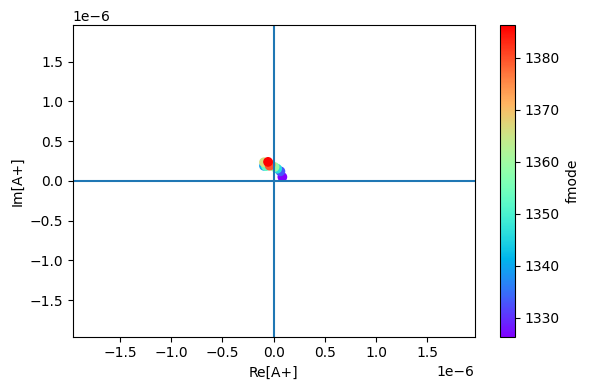

1340.6285172323635
Search Successful!
Fmode = 1341Hz


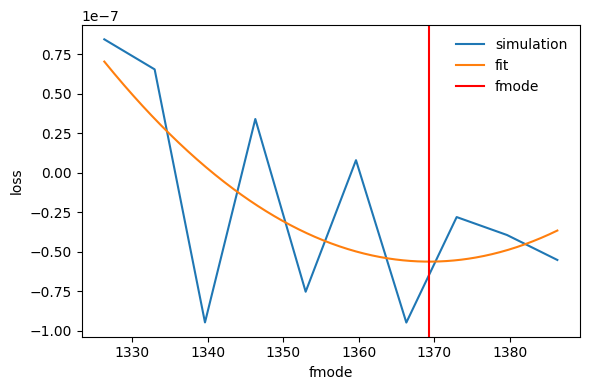

1398.0358065664027 1340.6754564721523
1369.3556315192775


In [21]:
hw = hw3
fmin = fguess-hw
fmax = fguess+hw

for_loop = tqdm(np.linspace(fmin*2*np.pi + imag, fmax*2*np.pi + imag, 10))
# for_loop = tqdm([2.591e3 * 2 * np.pi + imag, 2.591e3 * 2 * np.pi + imag, 2.591e3 * 2 * np.pi + imag])

omega_vals = []
loss_vals = []
abs_loss_vals = []

for omega in for_loop:

    p_c, e_c, m0, omega, l, nl, nu0, Q0, b0, W0, K0, X0, H00, H10, init_VEC, \
    p_max, p_min, r_i, p0, e0 = initial_conditions(EOS, e_arr, p_arr, index, omega)

    p, m, r_arr, nu, h1, k, w, x = tov(EOS, init_VEC, r_i, p_min,p_max, 
                               omega, nl, progress = False, l = l, 
                                       n_iter_max = 20000 * 10)

    max_idx, m_R, r_R, p_R, ec_R, nu_R, h1_R, k_R, w_R, x_R, schild, \
    interior = surface_conditions(p, m, r_arr, nu, h1, k, w, x)

    # Update init_VEC
    nu_ext = -lamba_metric(m_R, r_R)
    nu_int = nu_R #At surface
    delta_nu = nu_int - nu_ext
    nu0 =  nu0 - delta_nu

    X0, H00, H10 = initial_conditions_helper(K0, e_c, p_c, nu0, omega, W0, nl, l, p0, e0)
    init_VEC = [p_c, m0, nu0, H10, K0, W0, X0]
    time.sleep(0.2)

    p, m, r_arr, nu, h1, k, w, x = tov(EOS, init_VEC, r_i, p_min,p_max, 
                               omega, nl, progress = False, l = l)

    max_idx, m_R, r_R, p_R, ec_R, nu_R, h1_R, k_R, w_R, x_R, schild, \
    interior = surface_conditions(p, m, r_arr, nu, h1, k, w, x)

    # Update init_VEC
    nu_ext = -lamba_metric(m_R, r_R)
    nu_int = nu_R #At surface
    delta_nu = nu_int - nu_ext
    nu0 =  nu0 - delta_nu

    X0, H00, H10 = initial_conditions_helper(K0, e_c, p_c, nu0, omega, W0, nl, l, p0, e0)
    init_VEC = [p_c, m0, nu0, H10, K0, W0, X0]
    time.sleep(0.2)

    p, m, r_arr, nu, h1, k, w, x = tov(EOS, init_VEC, r_i, p_min,p_max, 
                               omega, nl, progress = False, l = l)

    max_idx, m_R, r_R, p_R, ec_R, nu_R, h1_R, k_R, w_R, x_R, schild, \
    interior = surface_conditions(p, m, r_arr, nu, h1, k, w, x)

    
    if r_R < 3*km2cm:
        print(f"[ERROR] Radius is only {r_R/km2cm}km. Skipping...")
        continue

    def optimize_x_R(K0):

        # Update Initial Conditions in terms of K0    
        X0, H00, H10 = initial_conditions_helper(K0, e_c, p_c, nu0, omega, W0, nl, l, p0, e0)
        init_VEC = np.array([p_c, m0, nu0, H10, K0, W0, X0], dtype = complex).flatten()
        p, m, r_arr, nu, h1, k, w, x = tov(EOS, init_VEC, r_i, p_min,p_max, 
                                           omega, nl, progress = False, l = l, n_iter_max = 20000)
        max_idx, m_R, r_R, p_R, ec_R, nu_R, h1_R, k_R, w_R, x_R, schild, \
        interior = surface_conditions(p, m, r_arr, nu, h1, k, w, x)
        loss = np.log10(abs(x_R)) # Absolute loss of complex B.C.
        return loss

    K0_guess = K0
    init_guess = [K0_guess]
    res = minimize(optimize_x_R, x0 = init_guess, method='Nelder-Mead', 
                   options = {"disp": True, "maxiter":20, "fatol": 1e-20})


    K0 = res.x[0]
    X0_factor = (e_c + p_c) * np.exp(nu0/2)
    X0_term1 = 4 * np.pi/3 * (e_c + 3*p_c) * W0 * G/(c**4)
    X0_term2 = -(omega**2)/l * np.exp(-nu0) * W0  /(c**2)
    X0_term3 = K0/2
    X0 = X0_factor * (X0_term1 + X0_term2 + X0_term3)
    H00 = K0
    H10 = (l*K0 + 8*np.pi*(G/(c**4))*(e_c+p_c)*W0)/((nl+1))

    init_VEC = [p_c, m0, nu0, H10, K0, W0, X0]
    time.sleep(0.2)

    p, m, r_arr, nu, h1, k, w, x = tov(EOS, init_VEC, r_i, p_min,p_max, 
                               omega, nl, progress = False, l = l)

    max_idx, m_R, r_R, p_R, ec_R, nu_R, h1_R, k_R, w_R, x_R, schild, \
    interior = surface_conditions(p, m, r_arr, nu, h1, k, w, x)
    

    
    h1r = h1_R
    Kr = k_R
    b = _b(r_R, m_R)
    n = nl
    r = r_R
    z_R = r*(Kr/(1 - 2*b) - h1r)/(-(-3*b**2 - 3*b*n + n)/((1 - 2*b)*(3*b + n)) + (6*b**2 + 3*b*n + n*(n + 1))/((1 - 2*b)*(3*b + n)))
    dzdR_R = (-Kr*(-3*b**2 - 3*b*n + n)/((1 - 2*b)*(3*b + n)) + h1r*(6*b**2 + 3*b*n + n*(n + 1))/(3*b + n))/(-(-3*b**2 - 3*b*n + n)/((1 - 2*b)*(3*b + n)) + (6*b**2 + 3*b*n + n*(n + 1))/((1 - 2*b)*(3*b + n)))
    z0 = [z_R, dzdR_R]
#     print(z0, r_R)

    alpha0, alpha1, alpha2 = alphas(omega, nl, m_R)
    # From surface to inf
    r_vals = np.linspace(r_R, 25 * c / np.real(omega), 500)
    r_star_vals = r_star_func(r_vals, np.real(m_R))
    z, dzdr_star, r_int = zrly(omega, r_star_vals, progress = False)
    # Save final values
    zFinal = z[-1]
    zPrimeFinal = dzdr_star[-1]
    rFinal = r_vals[-1]
    rStarFinal = r_star_vals[-1]

    b = _b(rFinal, m_R)
    
    
    # Z+/-
    zMinus = np.exp(-1j*(omega/c)*rStarFinal) * (alpha0 + alpha1/rFinal + alpha2/(rFinal**2))
    zPlus = np.conjugate(zMinus)

    # Zprime +/-
    zPrimeMinus = -1j*(omega/c)*np.exp(-1j*(omega/c)*rStarFinal) \
                * (alpha0 + alpha1/rFinal + (alpha2 + 1j*alpha1*(1-2*b)*c/omega)/(rFinal**2))
    zPrimePlus = np.conjugate(zPrimeMinus)

    # A+
    A_plus = -zFinal*zPrimeMinus/(zMinus*zPrimePlus - zPlus*zPrimeMinus) \
            + zMinus*zPrimeFinal/(zMinus*zPrimePlus - zPlus*zPrimeMinus)

    # A-
    A_minus = -zFinal*zPrimePlus/(-zMinus*zPrimePlus + zPlus*zPrimeMinus) \
             + zPlus*zPrimeFinal/(-zMinus*zPrimePlus + zPlus*zPrimeMinus)

    loss = A_plus
    abs_loss = abs(loss)
    
    if abs_loss > 1e3:
        continue
        
    omega_vals.append(omega)
    loss_vals.append(loss)
    abs_loss_vals.append(abs_loss)

omega_arr = np.array(omega_vals)
loss_arr = np.array(loss_vals)
abs_loss_arr = np.array(abs_loss_vals)
fmode_arr = np.real(omega_arr/(2*np.pi))

plt.figure(dpi = 100)
sc = plt.scatter(np.real(loss_arr),np.imag(loss_arr), c = 
                 fmode_arr, cmap = cm.rainbow)
plt.xlabel("Re[A+]")
plt.ylabel("Im[A+]")
plt.colorbar(sc, label = "fmode")
plt.tight_layout()
plt.axhline(0)
plt.axvline(0)
lim = 20*min(np.abs(loss_arr))
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
plt.show()

def quadratic(x, a, b, c):
    return a*(x**2)+b*(x)+c

vec = np.real(loss_arr)
popt, pcov = curve_fit(quadratic, xdata = np.real(fmode_arr), ydata = vec)
f_arr = np.linspace(fmin*2*np.pi + imag, fmax*2*np.pi + imag, 500)/(2*np.pi)
fmode = np.real(f_arr[np.argmin(np.abs(quadratic(np.real(f_arr), *popt)))])
print(fmode)

if np.isclose(np.real(fmode), min(np.real(fmode_arr))) or np.isclose(np.real(fmode), max(np.real(fmode_arr))):
    print("Search Failed")
else:
    print(f"Search Successful!\nFmode = {round(fmode)}Hz")

_math_a,_math_b,_math_c = popt
det = np.sqrt(_math_b**2 - 4*_math_a*_math_c)
fmode1 = (-_math_b + det)/(2*_math_a)
fmode2 = (-_math_b - det)/(2*_math_a)

if abs(fmode1 - fmode2)<250:
    fmode = (fmode1 + fmode2)/2
    
plt.figure(dpi = 100)
plt.plot(np.real(fmode_arr), vec, label = "simulation")
plt.plot(np.real(f_arr), quadratic(np.real(f_arr), *popt), label = "fit")
plt.axvline(fmode, label = "fmode", color = "red")
plt.xlabel("fmode")
plt.ylabel("loss")
plt.legend()
plt.show()


print(fmode1, fmode2)
print(fmode)

fguess = fmode
    # print(np.array([h1[0], -k[0], x[0], w[0]]))